<a href="https://colab.research.google.com/github/carlosjimenez88M/Applied-Machine-Learning-to-Environmental-Issues/blob/master/experiments/South_Carolina_Real_Estate_Pricing_Models_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
### Libraries ----

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

In [3]:
from google.colab import files
files.upload()

Saving realestate_data_southcarolina_2025.csv to realestate_data_southcarolina_2025.csv


{'realestate_data_southcarolina_2025.csv': b'\xef\xbb\xbf"type","sub_type","sqft","baths","beds","stories","year_built","listPrice"\r\n"condos","condo","1268","2","3","1","2002","199900"\r\n"condos","condo","969","2","2","7","1985","119900"\r\n"single_family",,"2181","3","3","2",,"100000"\r\n"single_family",,"2083","2","3",,"1983","309900"\r\n"land",,,"0",,,,"1000"\r\n"land",,,,,,,"27500"\r\n"land",,,"0",,,,"49000"\r\n"land",,,"0",,,,"1000"\r\n"single_family",,"1200","1","3","1",,"63000"\r\n"single_family",,"1104","2","2","1","1974","79900"\r\n"land",,,"0",,,,"1000"\r\n"land",,,,,,,"35000"\r\n"single_family",,"1236","2","3","2",,"50000"\r\n"land",,,"0",,,,"1000"\r\n"land",,,"0",,,,"33500"\r\n"land",,,,,,,"28000"\r\n"land",,,"0",,,,"76700"\r\n"single_family",,"1564","3","3","2","1989","705000"\r\n"single_family",,"774","1","2","1","1940","5000"\r\n"land",,,"0",,,,"45000"\r\n"single_family",,"920","1","3",,"1953","168000"\r\n"condos","condo","1200","2","3","1","1985","98500"\r\n"single_f

In [4]:
df = pd.read_csv('realestate_data_southcarolina_2025.csv')
df.head()

,type,sub_type,sqft,baths,beds,stories,year_built,listPrice
0,condos,condo,1268.0,2.0,3.0,1.0,2002.0,199900.0
1,condos,condo,969.0,2.0,2.0,7.0,1985.0,119900.0
2,single_family,NaN,2181.0,3.0,3.0,2.0,NaN,100000.0
3,single_family,NaN,2083.0,2.0,3.0,NaN,1983.0,309900.0
4,land,NaN,NaN,0.0,NaN,NaN,NaN,1000.0


### Understand Missing Values

In [5]:

def determine_missing_data_nature(df):
    """
    Determines the nature of missing data (MCAR, MAR, MNAR) in a DataFrame.

    This function provides an initial assessment based on correlations between
    missingness patterns and observed data. It does not provide a definitive
    answer for MNAR, which often requires domain knowledge.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        dict: A dictionary containing information about missing data:
              - 'missing_counts': Number of missing values per column.
              - 'missing_percentages': Percentage of missing values per column.
              - 'missing_correlations': Correlation matrix of missingness indicators.
              - 'missing_by_variable_correlations': Correlation between missingness
                                                    of each column and the values of other variables.
    """
    missing_counts = df.isnull().sum()
    missing_percentages = (missing_counts / len(df)) * 100

    # Analyze correlations of missingness
    missing_indicator = df.isnull().astype(int)
    missing_correlations = missing_indicator.corr()

    # Correlation between missingness of each column and the observed variables
    missing_by_variable_correlations = {}

    for col in df.columns:
        if missing_counts[col] > 0:
            # Skip if the entire column is missing
            if missing_counts[col] == len(df):
                missing_by_variable_correlations[col] = "All values missing"
                continue

            try:
                if pd.api.types.is_numeric_dtype(df[col]):
                    # Correlation with mean-imputed values (approximation)
                    imputed = df[col].fillna(df[col].mean())
                    corr = missing_indicator[col].corr(imputed)
                    missing_by_variable_correlations[col] = round(corr, 4)

                elif pd.api.types.is_bool_dtype(df[col]) or pd.api.types.is_categorical_dtype(df[col]):
                    imputed = df[col].astype(int).fillna(0)
                    corr = missing_indicator[col].corr(imputed)
                    missing_by_variable_correlations[col] = round(corr, 4)

                elif pd.api.types.is_object_dtype(df[col]):
                    # One-hot encode the categorical variable
                    encoded = pd.get_dummies(df[col], dummy_na=True)
                    corr = encoded.corrwith(missing_indicator[col]).abs().max()
                    missing_by_variable_correlations[col] = round(corr, 4)

                elif pd.api.types.is_datetime64_any_dtype(df[col]):
                    # Optionally extract year, month, etc. for more analysis
                    missing_by_variable_correlations[col] = "N/A (datetime not handled)"

                else:
                    missing_by_variable_correlations[col] = "N/A (unsupported dtype)"

            except Exception as e:
                missing_by_variable_correlations[col] = f"Error: {str(e)}"

    return {
        'missing_counts': missing_counts,
        'missing_percentages': missing_percentages,
        'missing_correlations': missing_correlations,
        'missing_by_variable_correlations': missing_by_variable_correlations
    }


In [6]:
missing_data_analysis = determine_missing_data_nature(df)

In [7]:
print("Missing Value Counts:\n", missing_data_analysis['missing_counts'])
print("\nMissing Value Percentages:\n", missing_data_analysis['missing_percentages'])
print("\nMissingness Correlations:\n", missing_data_analysis['missing_correlations'])
print("\nMissingness by Variable Correlations:\n", missing_data_analysis['missing_by_variable_correlations'])

Missing Value Counts:
 type             3
sub_type      4332
sqft           804
baths          378
beds           751
stories       1481
year_built    1622
listPrice       28
dtype: int64

Missing Value Percentages:
 type           0.059988
sub_type      86.622675
sqft          16.076785
baths          7.558488
beds          15.016997
stories       29.614077
year_built    32.433513
listPrice      0.559888
dtype: float64

Missingness Correlations:
                 type  sub_type      sqft     baths      beds   stories  \
type        1.000000  0.009628 -0.010723  0.085680 -0.010299 -0.015892   
sub_type    0.009628  1.000000  0.164004  0.112371  0.124086  0.087642   
sqft       -0.010723  0.164004  1.000000  0.101386  0.904050  0.580568   
baths       0.085680  0.112371  0.101386  1.000000  0.131788  0.033236   
beds       -0.010299  0.124086  0.904050  0.131788  1.000000  0.613738   
stories    -0.015892  0.087642  0.580568  0.033236  0.613738  1.000000   
year_built  0.035362  0.184433

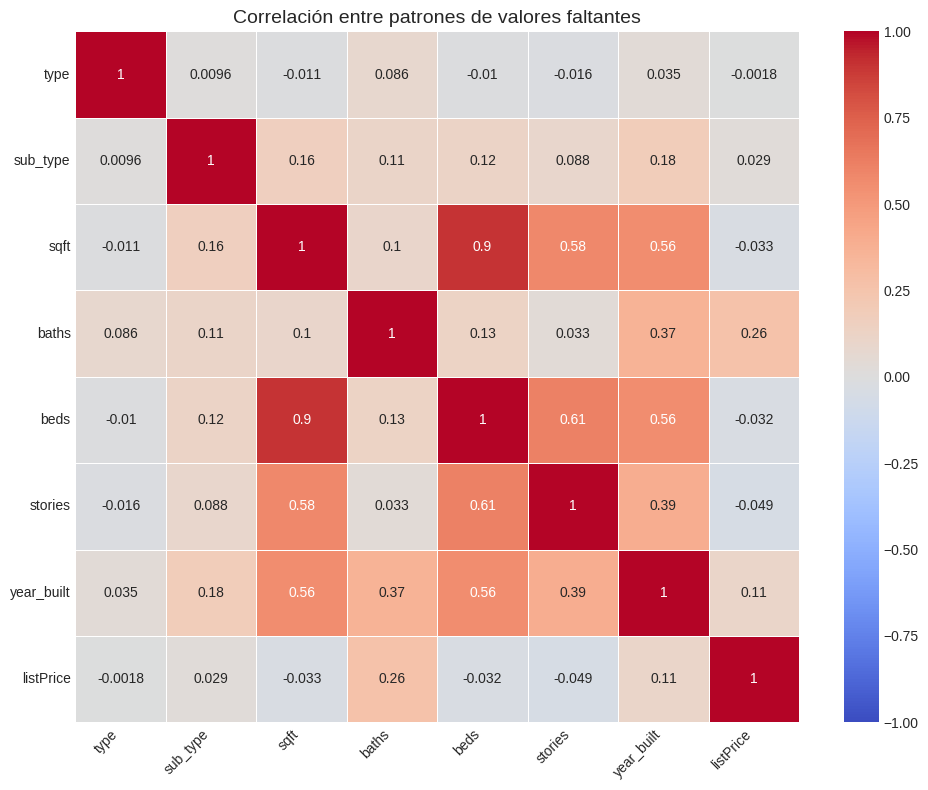

In [8]:
missing_indicator = df.isnull().astype(int)
corr_matrix = missing_indicator.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix,
            annot=True,
            cmap='coolwarm',
            linewidths=0.5,
            vmin=-1,
            vmax=1)
plt.title("Correlación entre patrones de valores faltantes", fontsize=14)
plt.xticks(rotation=45,
           ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [9]:
missing_values = (
    df
    .isnull()
    .sum()).sort_values(ascending=False
).reset_index(name='missing_count')


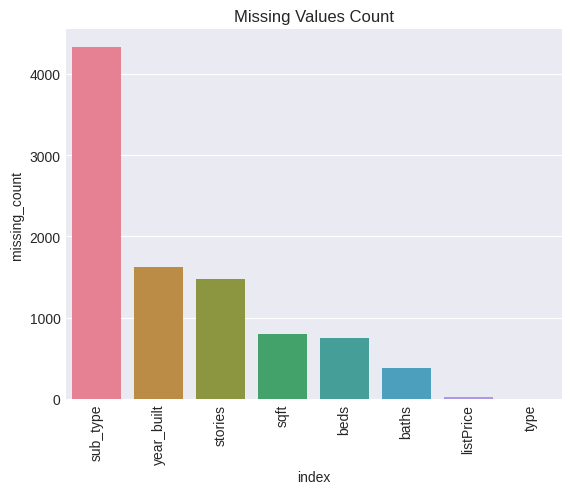

In [10]:
sns.barplot(x='index',
            y='missing_count',
            hue='index',
            data=missing_values)
plt.xticks(rotation=90)
plt.title('Missing Values Count')
plt.show()

In [11]:
df = df.dropna(subset='listPrice').reset_index(drop=True)
df

,type,sub_type,sqft,baths,beds,stories,year_built,listPrice
0,condos,condo,1268.0,2.0,3.0,1.0,2002.0,199900.0
1,condos,condo,969.0,2.0,2.0,7.0,1985.0,119900.0
2,single_family,NaN,2181.0,3.0,3.0,2.0,NaN,100000.0
3,single_family,NaN,2083.0,2.0,3.0,NaN,1983.0,309900.0
4,land,NaN,NaN,0.0,NaN,NaN,NaN,1000.0
...,...,...,...,...,...,...,...,...
4968,single_family,NaN,2088.0,3.0,3.0,2.0,NaN,344900.0
4969,single_family,NaN,1417.0,2.0,3.0,1.0,2020.0,320000.0
4970,single_family,NaN,3656.0,3.0,3.0,2.0,2009.0,759900.0
4971,single_family,NaN,1125.0,2.0,4.0,1.0,1972.0,160000.0


In [12]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [13]:
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [14]:

def compare_imputers(df, column, test_size=0.1, n_neighbors=5, random_state=42):
    """
    Compares Median, KNN, and IterativeImputer on a numerical column.

    Args:
        df (pd.DataFrame): DataFrame with numerical data.
        column (str): Column to evaluate.
        test_size (float): Fraction of known values to mask.
        n_neighbors (int): Neighbors for KNNImputer.
        random_state (int): For reproducibility.

    Returns:
        dict: MAE and RMSE for each imputation method.
    """
    df_copy = df.copy()
    numeric_df = df_copy.select_dtypes(include=[np.number])


    known = numeric_df[column].dropna()
    test_indices = known.sample(frac=test_size, random_state=random_state).index
    true_values = numeric_df.loc[test_indices, column].copy()
    numeric_df.loc[test_indices, column] = np.nan

    results = {}


    median_imputer = SimpleImputer(strategy='median')
    median_df = median_imputer.fit_transform(numeric_df)
    median_imputed = pd.DataFrame(median_df, columns=numeric_df.columns, index=numeric_df.index)
    results['Median MAE'] = mean_absolute_error(true_values, median_imputed.loc[test_indices, column])
    results['Median RMSE'] = mean_squared_error(true_values, median_imputed.loc[test_indices, column])


    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    knn_df = knn_imputer.fit_transform(numeric_df)
    knn_imputed = pd.DataFrame(knn_df, columns=numeric_df.columns, index=numeric_df.index)
    results['KNN MAE'] = mean_absolute_error(true_values, knn_imputed.loc[test_indices, column])
    results['KNN RMSE'] = mean_squared_error(true_values, knn_imputed.loc[test_indices, column])


    iterative_imputer = IterativeImputer(random_state=random_state)
    iter_df = iterative_imputer.fit_transform(numeric_df)
    iter_imputed = pd.DataFrame(iter_df, columns=numeric_df.columns, index=numeric_df.index)
    results['Iterative MAE'] = mean_absolute_error(true_values, iter_imputed.loc[test_indices, column])
    results['Iterative RMSE'] = mean_squared_error(true_values, iter_imputed.loc[test_indices, column])

    return results

In [15]:
compare_imputers(df, column='sqft')

{'Median MAE': 716.2721822541967,
 'Median RMSE': 1088618.7056354915,
 'KNN MAE': 541.5026378896882,
 'KNN RMSE': 582191.8517985612,
 'Iterative MAE': 381.2749835241979,
 'Iterative RMSE': 286880.9724922018}

In [16]:
def plot_imputation_comparison(results):
    mae_keys = [k for k in results if 'MAE' in k]
    rmse_keys = [k for k in results if 'RMSE' in k]

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # MAE
    mae_vals = [results[k] for k in mae_keys]
    ax[0].bar(mae_keys, mae_vals)
    ax[0].set_title("MAE por método de imputación")
    ax[0].set_ylabel("MAE")
    ax[0].tick_params(axis='x', rotation=45)

    # RMSE
    rmse_vals = [results[k] for k in rmse_keys]
    ax[1].bar(rmse_keys, rmse_vals, color='orange')
    ax[1].set_title("RMSE por método de imputación")
    ax[1].set_ylabel("RMSE")
    ax[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

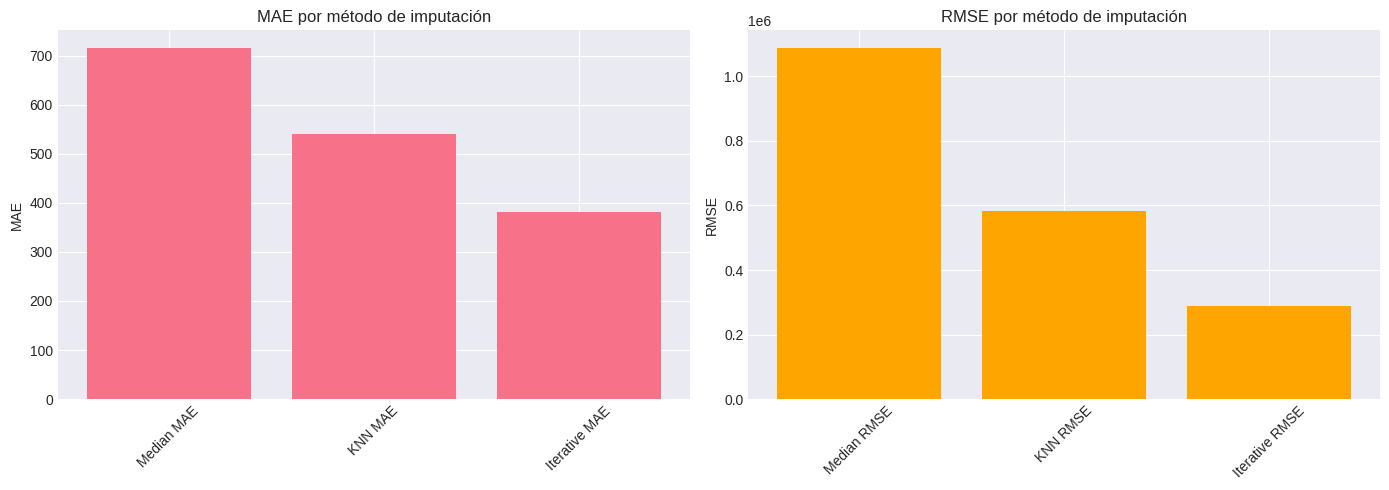

In [17]:
plot_imputation_comparison(compare_imputers(df, column='sqft'))

Variable sqft


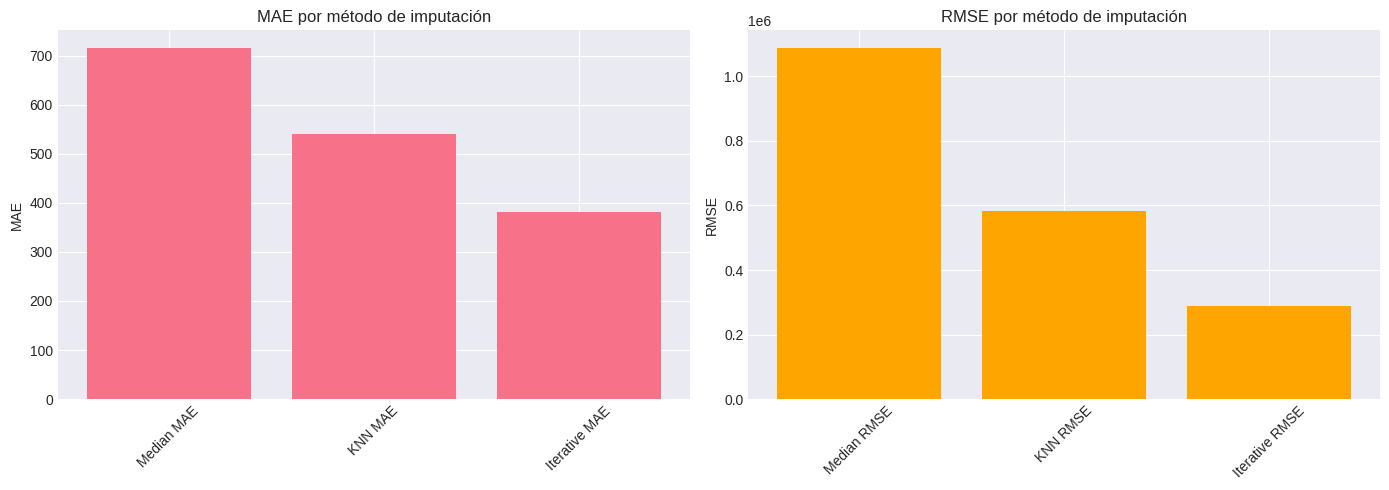

Variable baths


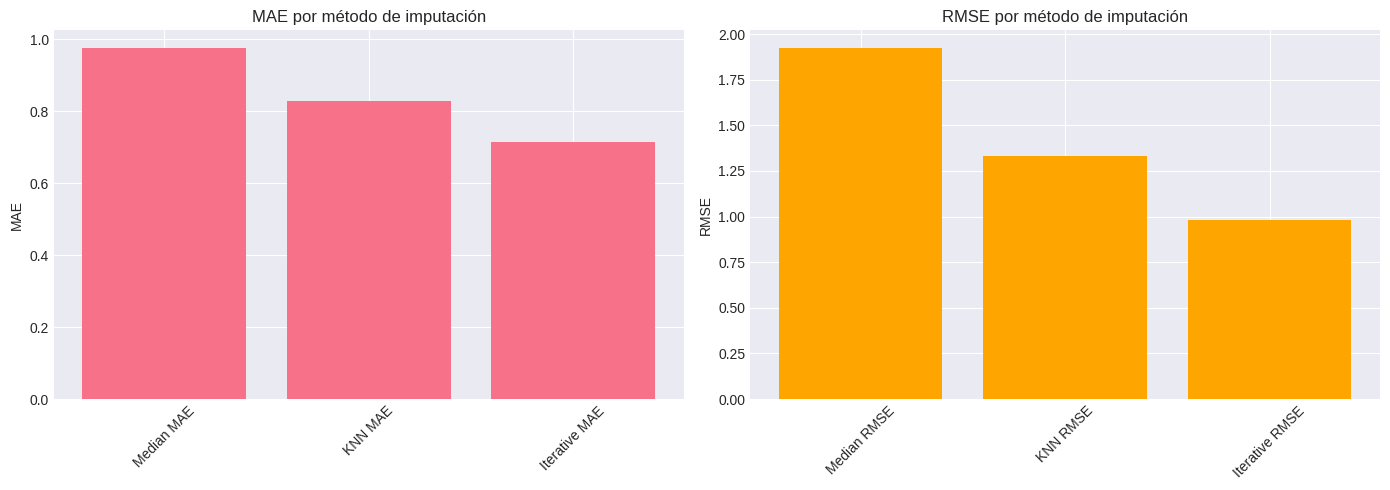

Variable beds


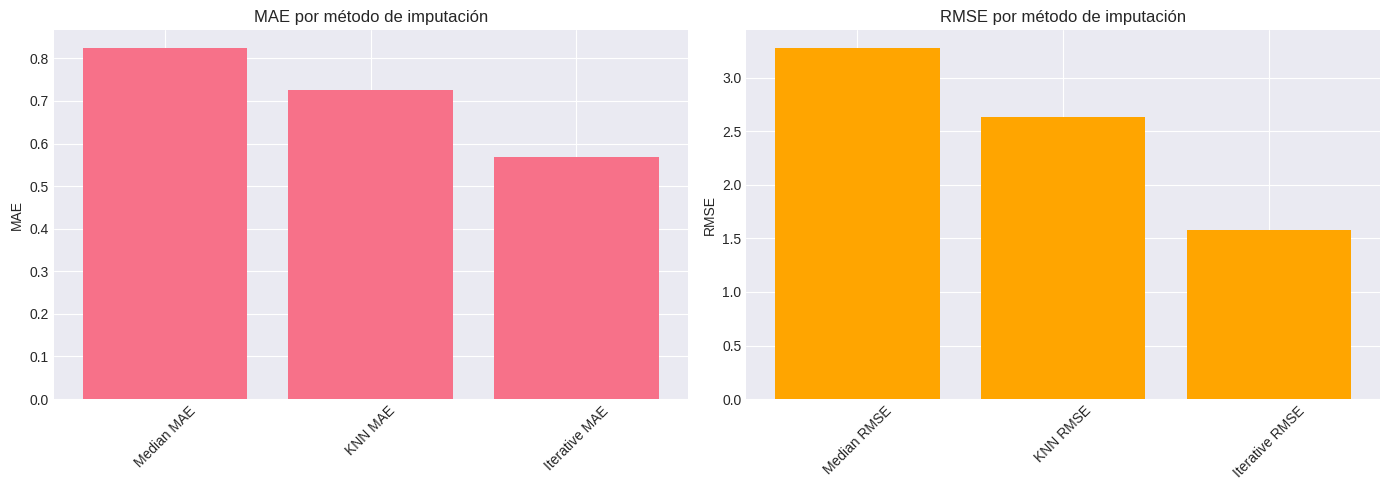

Variable stories


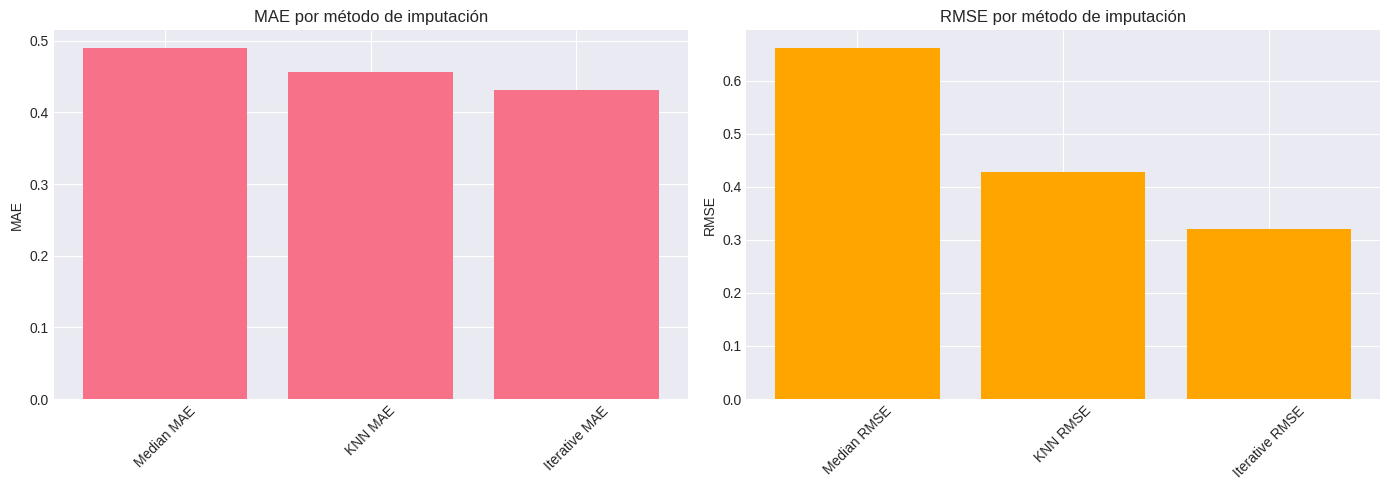

Variable year_built


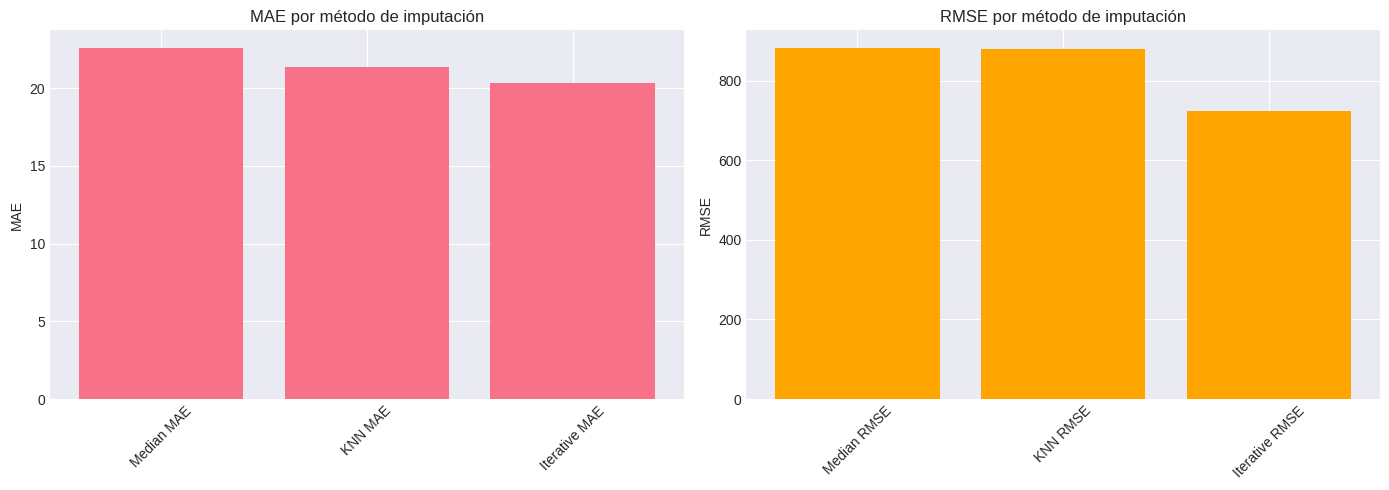

Variable listPrice


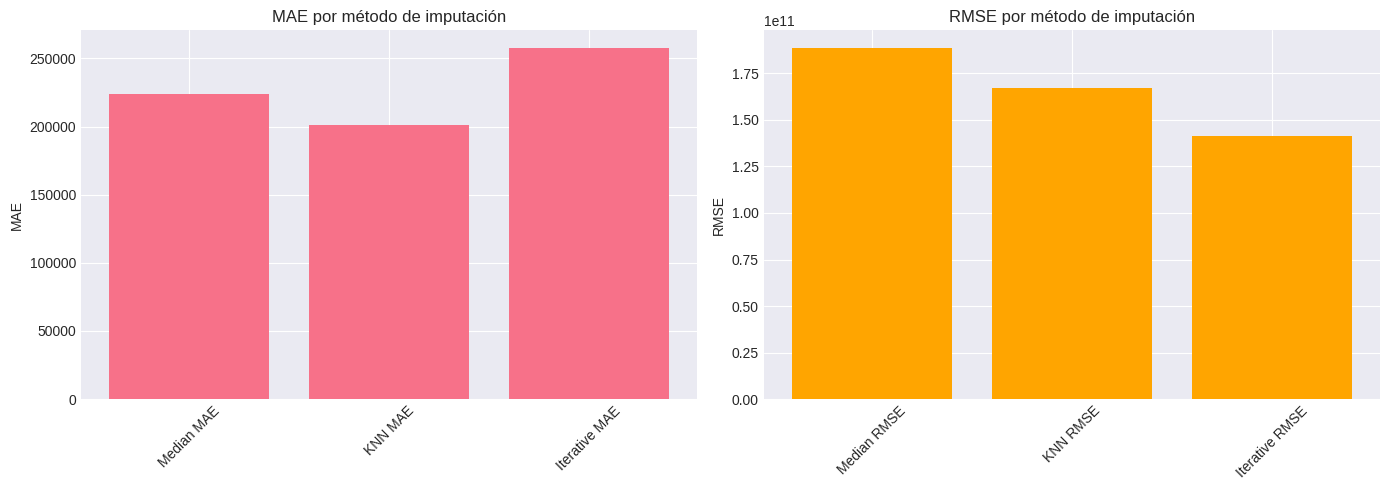

In [18]:
for i in df.select_dtypes(include=[np.number]).columns:
  print(f'Variable {i}')
  plot_imputation_comparison(compare_imputers(df, column=i))
  plt.show()

In [19]:
## Drop na list_prince
## Iteractive imputation

df_remove_listPirce = df.dropna(subset='listPrice').reset_index(drop=True)


In [20]:
df_remove_listPirce

,type,sub_type,sqft,baths,beds,stories,year_built,listPrice
0,condos,condo,1268.0,2.0,3.0,1.0,2002.0,199900.0
1,condos,condo,969.0,2.0,2.0,7.0,1985.0,119900.0
2,single_family,NaN,2181.0,3.0,3.0,2.0,NaN,100000.0
3,single_family,NaN,2083.0,2.0,3.0,NaN,1983.0,309900.0
4,land,NaN,NaN,0.0,NaN,NaN,NaN,1000.0
...,...,...,...,...,...,...,...,...
4968,single_family,NaN,2088.0,3.0,3.0,2.0,NaN,344900.0
4969,single_family,NaN,1417.0,2.0,3.0,1.0,2020.0,320000.0
4970,single_family,NaN,3656.0,3.0,3.0,2.0,2009.0,759900.0
4971,single_family,NaN,1125.0,2.0,4.0,1.0,1972.0,160000.0


In [21]:
def apply_iterative_imputation(df, random_state=42):
    """
    Aplica IterativeImputer a todas las columnas numéricas con valores faltantes del DataFrame.

    Args:
        df (pd.DataFrame): DataFrame original con valores faltantes.
        random_state (int): Semilla para reproducibilidad.

    Returns:
        pd.DataFrame: Nuevo DataFrame imputado (solo columnas numéricas).
    """
    df_copy = df.copy()
    numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
    imputer = IterativeImputer(random_state=random_state)


    df_copy[numeric_cols] = imputer.fit_transform(df_copy[numeric_cols])

    return df_copy


In [22]:
df_imputed = apply_iterative_imputation(df)

In [23]:
df_imputed = df_imputed.dropna(subset='type').reset_index(drop=True)


In [24]:
df_imputed.isna().sum()

,0
type,0
sub_type,4301
sqft,0
baths,0
beds,0
stories,0
year_built,0
listPrice,0


In [25]:
df_imputed_clean = df_imputed.drop(columns=['sub_type'] )

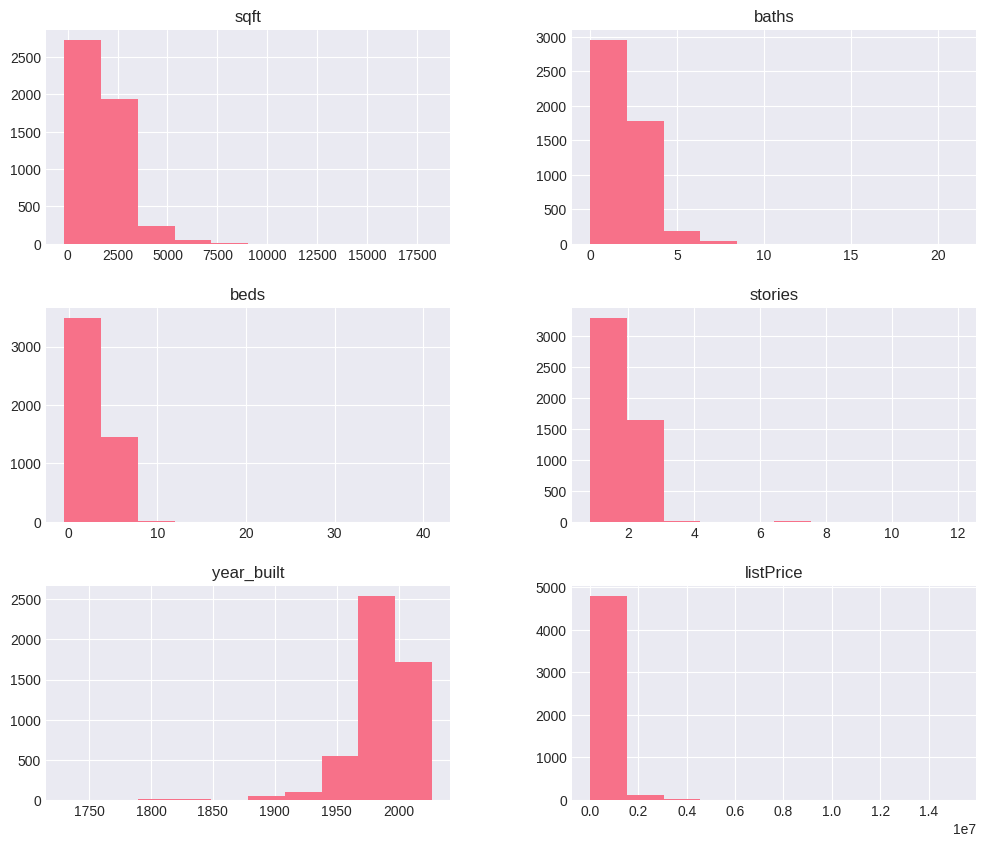

In [26]:
df_imputed_clean.hist(figsize=(12, 10))
plt.show()

### Exploratory Data Analysis

In [27]:
df_imputed_clean.head()

,type,sqft,baths,beds,stories,year_built,listPrice
0,condos,1268.000000,2.0,3.000000,1.000000,2002.000000,199900.0
1,condos,969.000000,2.0,2.000000,7.000000,1985.000000,119900.0
2,single_family,2181.000000,3.0,3.000000,2.000000,1995.505202,100000.0
3,single_family,2083.000000,2.0,3.000000,1.388688,1983.000000,309900.0
4,land,301.908921,0.0,1.864135,0.834177,1970.602534,1000.0


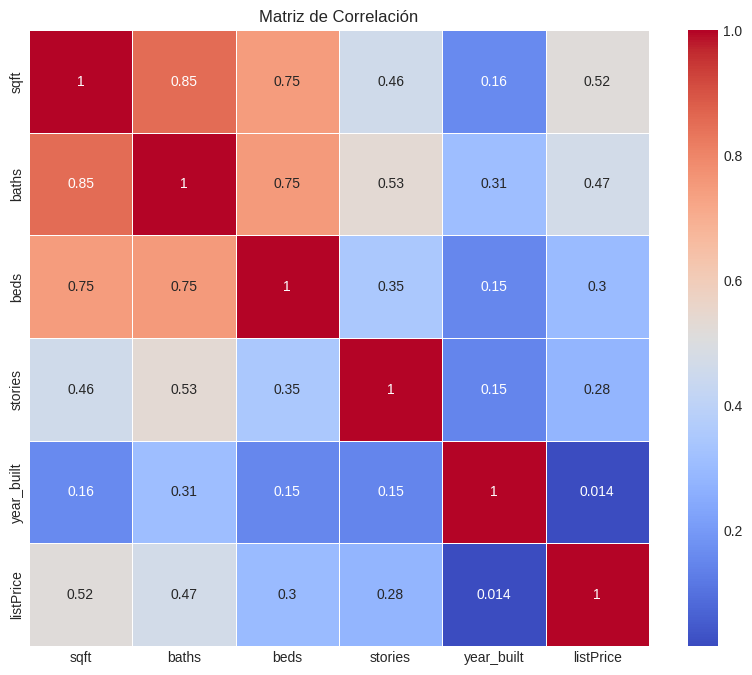

In [28]:
correlation_matrix = df_imputed_clean.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

In [29]:
price_correlations = correlation_matrix['listPrice'].sort_values(ascending=False)
print("Top Correlations with List Price:")
print("="*40)
for feature, corr in price_correlations.items():
    if feature != 'listPrice':
        print(f"{feature:20} : {corr:.3f}")

Top Correlations with List Price:
sqft                 : 0.515
baths                : 0.466
beds                 : 0.297
stories              : 0.277
year_built           : 0.014


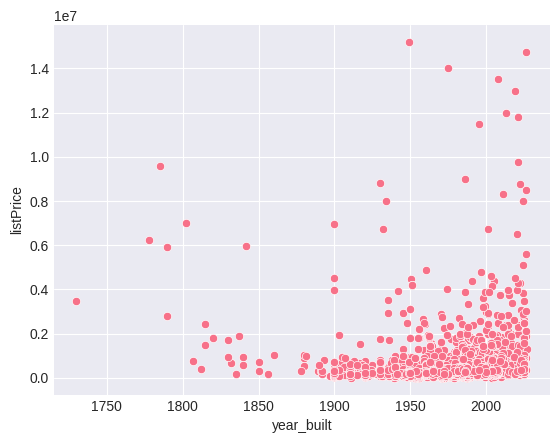

In [30]:
sns.scatterplot(data=df_imputed_clean,
                y='listPrice',
                x='year_built')
plt.show()

In [31]:
### Filter by 1900
df_imputed_clean = df_imputed_clean[df_imputed_clean['year_built'] >= 1900]

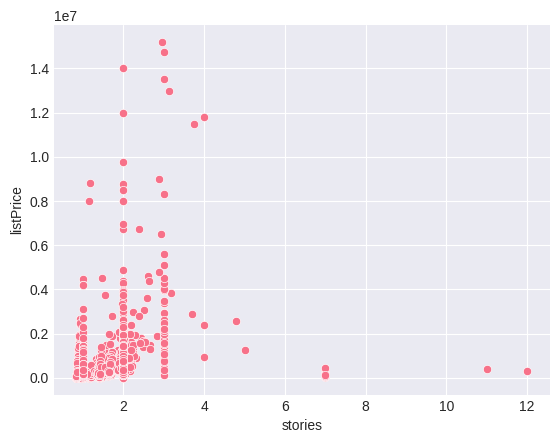

In [32]:
sns.scatterplot(data=df_imputed_clean,
                y='listPrice',
                x='stories')
plt.show()

In [33]:
## Filter stories < 6
df_imputed_clean = df_imputed_clean[df_imputed_clean['stories'] < 6]

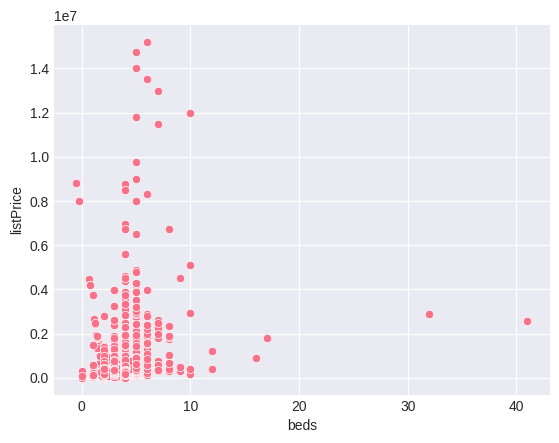

In [34]:
sns.scatterplot(data=df_imputed_clean,
                y='listPrice',
                x='beds')
plt.show()

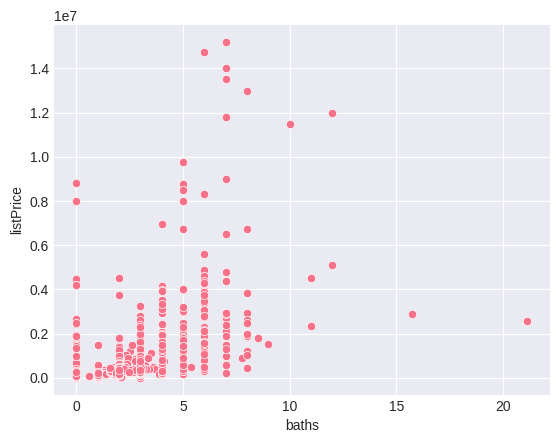

In [35]:
###
sns.scatterplot(data=df_imputed_clean,
                y='listPrice',
                x='baths')
plt.show()


In [36]:
df_imputed_clean['baths'] = df_imputed_clean['baths'].astype('int')
df_imputed_clean['year_built'] = df_imputed_clean['year_built'].astype('int')
df_imputed_clean['beds'] = df_imputed_clean['beds'].astype('int')
df_imputed_clean['ratio_baths_sqrt'] = df_imputed_clean['sqft']/df_imputed_clean['baths']
df_imputed_clean['ratio_beds_sqrt'] = df_imputed_clean['sqft']/df_imputed_clean['beds']
df_imputed_clean['ratio_beds_baths'] = df_imputed_clean['beds']/df_imputed_clean['baths']
df_imputed_clean['sqft'] = abs(df_imputed_clean['sqft'])
df_imputed_clean['property_age'] = 2025 - df_imputed_clean['year_built']
df_imputed_clean['total_rooms'] = df_imputed_clean['beds'] + df_imputed_clean['baths']

In [37]:
price_correlations = correlation_matrix['listPrice'].sort_values(ascending=False)
print("Top Correlations with List Price:")
print("="*40)
for feature, corr in price_correlations.items():
    if feature != 'listPrice':
        print(f"{feature:20} : {corr:.3f}")

Top Correlations with List Price:
sqft                 : 0.515
baths                : 0.466
beds                 : 0.297
stories              : 0.277
year_built           : 0.014


In [38]:
df_imputed_clean['ratio_baths_sqrt'].replace([np.inf, -np.inf], 0, inplace=True)

In [39]:
df_imputed_clean.head()

,type,sqft,baths,beds,stories,year_built,listPrice,ratio_baths_sqrt,ratio_beds_sqrt,ratio_beds_baths,property_age,total_rooms
0,condos,1268.000000,2,3,1.000000,2002,199900.0,634.000000,422.666667,1.5,23,5
2,single_family,2181.000000,3,3,2.000000,1995,100000.0,727.000000,727.000000,1.0,30,6
3,single_family,2083.000000,2,3,1.388688,1983,309900.0,1041.500000,694.333333,1.5,42,5
4,land,301.908921,0,1,0.834177,1970,1000.0,0.000000,301.908921,inf,55,1
5,land,1613.596792,2,3,1.386682,1987,27500.0,806.798396,537.865597,1.5,38,5


In [40]:
df_imputed_clean['baths'].value_counts().reset_index()

,baths,count
0,2,2043
1,3,1201
2,0,620
3,1,447
4,4,372
5,5,127
6,6,60
7,7,23
8,8,12
9,11,2


In [41]:
df_imputed_clean.select_dtypes(include=[np.number]).corr()['listPrice'].sort_values(ascending=False)


,listPrice
listPrice,1.000000
sqft,0.508617
baths,0.463621
ratio_beds_sqrt,0.419095
total_rooms,0.401261
stories,0.339293
beds,0.299706
ratio_baths_sqrt,0.114712
year_built,0.113184
property_age,-0.113184


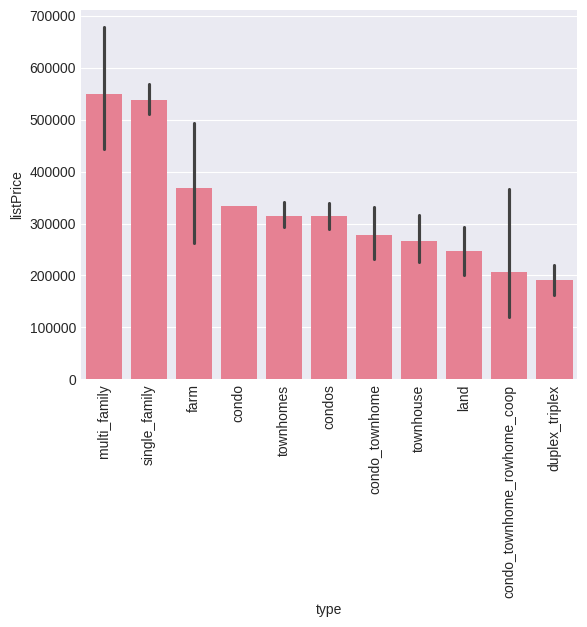

In [42]:
order = df_imputed_clean.groupby('type')['listPrice'].mean().sort_values(ascending=False).index

sns.barplot(data=df_imputed_clean,
            x='type',
            y='listPrice',
            order=order)
plt.xticks(rotation=90)
plt.show()

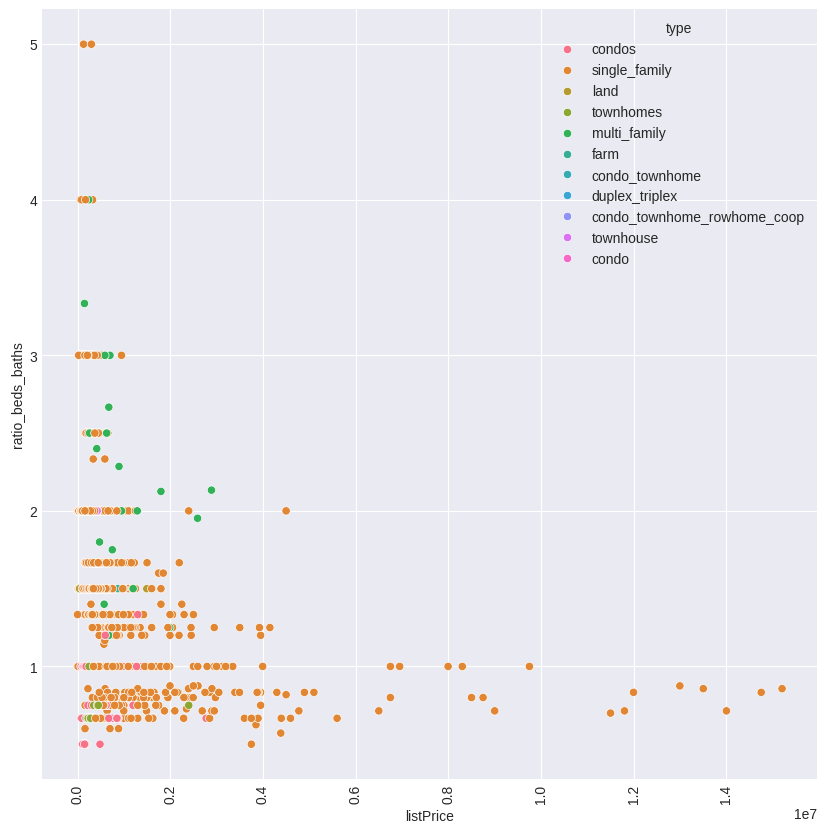

In [43]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df_imputed_clean,
            y='ratio_beds_baths',
            x='listPrice',
            hue='type')
plt.xticks(rotation=90)
plt.show()

In [44]:
df_imputed_clean.head()

,type,sqft,baths,beds,stories,year_built,listPrice,ratio_baths_sqrt,ratio_beds_sqrt,ratio_beds_baths,property_age,total_rooms
0,condos,1268.000000,2,3,1.000000,2002,199900.0,634.000000,422.666667,1.5,23,5
2,single_family,2181.000000,3,3,2.000000,1995,100000.0,727.000000,727.000000,1.0,30,6
3,single_family,2083.000000,2,3,1.388688,1983,309900.0,1041.500000,694.333333,1.5,42,5
4,land,301.908921,0,1,0.834177,1970,1000.0,0.000000,301.908921,inf,55,1
5,land,1613.596792,2,3,1.386682,1987,27500.0,806.798396,537.865597,1.5,38,5


In [45]:
result = (df_imputed_clean
          .groupby(['type'])
          .agg({
              'listPrice': [
                  'mean',
                  'median',
                  lambda x: x.quantile(0.25),
                  lambda x: x.quantile(0.75)
              ]
          })
          .reset_index())

result
result.columns = ['type', 'mean_price',
                  'median_price', 'P25_price', 'P75_price']

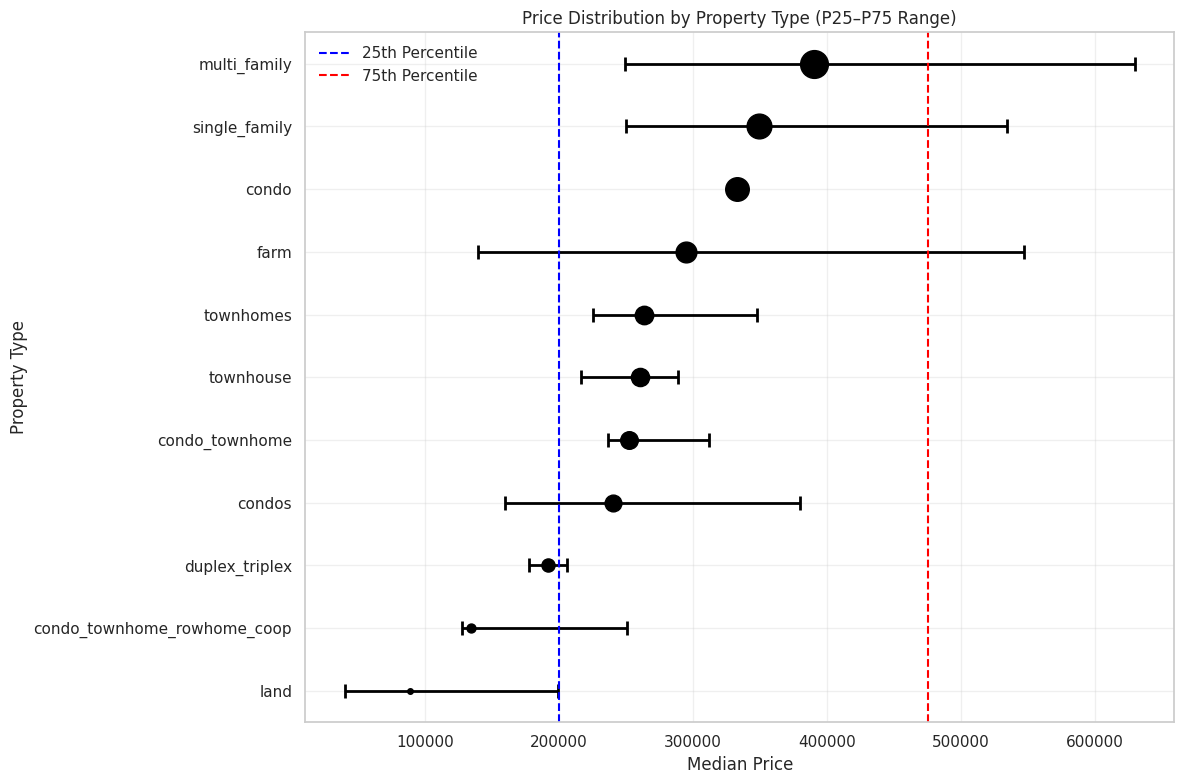

In [47]:
result_sorted = result.sort_values('median_price', ascending=True)


error_lower = result_sorted['median_price'] - result_sorted['P25_price']
error_upper = result_sorted['P75_price'] - result_sorted['median_price']
median_scaled = (result_sorted['median_price'] - result_sorted['median_price'].min()) / \
                (result_sorted['median_price'].max() - result_sorted['median_price'].min())


marker_sizes = 4 + median_scaled * 16


sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 8))


for i, (med, typ, err_low, err_up, size) in enumerate(zip(result_sorted['median_price'],
                                                          result_sorted['type'],
                                                          error_lower,
                                                          error_upper,
                                                          marker_sizes)):
    ax.errorbar(med, typ,
                xerr=[[err_low], [err_up]],
                fmt='o',
                color='black',
                capsize=5,
                capthick=2,
                elinewidth=2,
                markersize=size)


p25 = df_imputed_clean['listPrice'].quantile(0.25)
p75 = df_imputed_clean['listPrice'].quantile(0.75)

ax.axvline(p25, color='blue', linestyle='--', label='25th Percentile')
ax.axvline(p75, color='red', linestyle='--', label='75th Percentile')
ax.set_xlabel('Median Price')
ax.set_ylabel('Property Type')
ax.set_title('Price Distribution by Property Type (P25–P75 Range)')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()


In [48]:
result_sqrt = (df_imputed_clean
          .groupby(['type'])
          .agg({
              'sqft': [
                  'mean',
                  'median',
                  lambda x: x.quantile(0.25),
                  lambda x: x.quantile(0.75)
              ]
          })
          .reset_index())


result_sqrt.columns = ['type',
                       'mean_sqft',
                       'median_sqft',
                       'P25_sqft',
                       'P75_sqft']

result_sqrt

,type,mean_sqft,median_sqft,P25_sqft,P75_sqft
0,condo,2070.000000,2070.000000,2070.000000,2070.000000
1,condo_townhome,1674.500000,1593.500000,1430.250000,1912.000000
2,condo_townhome_rowhome_coop,1046.333333,872.000000,851.500000,1154.000000
3,condos,1113.380432,1050.000000,850.000000,1300.000000
4,duplex_triplex,2120.000000,2120.000000,1882.000000,2358.000000
5,farm,1568.790596,1685.041330,1631.315037,1772.679963
6,land,507.776931,321.263077,309.849087,359.640550
7,multi_family,2902.056062,2060.000000,1625.398289,3116.000000
8,single_family,2116.750868,1870.000000,1450.000000,2520.000000
9,townhomes,1584.130339,1506.500000,1362.500000,1708.000000


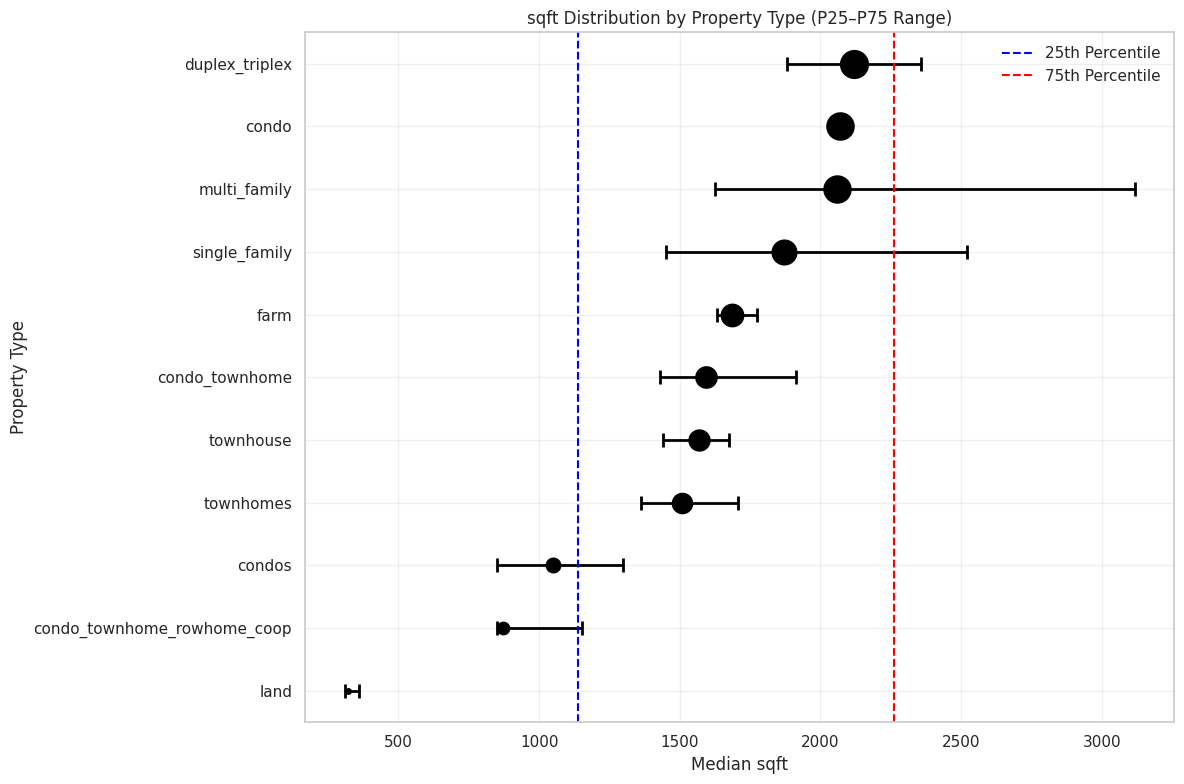

In [49]:
result_sorted = result_sqrt.sort_values('median_sqft', ascending=True)


error_lower = result_sorted['median_sqft'] - result_sorted['P25_sqft']
error_upper = result_sorted['P75_sqft'] - result_sorted['median_sqft']
median_scaled = (result_sorted['median_sqft'] - result_sorted['median_sqft'].min()) / \
                (result_sorted['median_sqft'].max() - result_sorted['median_sqft'].min())


marker_sizes = 4 + median_scaled * 16


sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 8))


for i, (med, typ, err_low, err_up, size) in enumerate(zip(result_sorted['median_sqft'],
                                                          result_sorted['type'],
                                                          error_lower,
                                                          error_upper,
                                                          marker_sizes)):
    ax.errorbar(med, typ,
                xerr=[[err_low], [err_up]],
                fmt='o',
                color='black',
                capsize=5,
                capthick=2,
                elinewidth=2,
                markersize=size)


p25 = df_imputed_clean['sqft'].quantile(0.25)
p75 = df_imputed_clean['sqft'].quantile(0.75)

ax.axvline(p25, color='blue', linestyle='--', label='25th Percentile')
ax.axvline(p75, color='red', linestyle='--', label='75th Percentile')
ax.set_xlabel('Median sqft')
ax.set_ylabel('Property Type')
ax.set_title('sqft Distribution by Property Type (P25–P75 Range)')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

In [50]:
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]



In [51]:
df_imputed_clean['stories'] = df_imputed_clean['stories'].astype('int')

In [52]:
df_imputed_clean['ratio_baths_sqrt'].replace([np.inf, -np.inf], 0, inplace=True)

In [53]:
df_imputed_clean[pd.isna(df_imputed_clean['ratio_beds_baths'])]


,type,sqft,baths,beds,stories,year_built,listPrice,ratio_baths_sqrt,ratio_beds_sqrt,ratio_beds_baths,property_age,total_rooms
109,single_family,121.010645,0,0,0,1978,5000.0,0.0,-inf,NaN,47,0
269,single_family,164.746882,0,0,0,2022,200000.0,0.0,-inf,NaN,3,0
772,single_family,89.044022,0,0,1,1977,217000.0,0.0,-inf,NaN,48,0
1547,land,1040.840686,0,0,1,1950,4468000.0,0.0,inf,NaN,75,0
1775,land,996.342668,0,0,0,1951,4199000.0,0.0,inf,NaN,74,0
1823,land,1625.104621,0,0,1,1933,8000000.0,0.0,inf,NaN,92,0
1886,land,996.508089,0,0,0,1951,4200000.0,0.0,inf,NaN,74,0
2011,land,1759.094934,0,0,1,1930,8810000.0,0.0,inf,NaN,95,0
2025,condos,256.000000,0,0,0,1976,17000.0,0.0,inf,NaN,49,0
2453,single_family,65.490985,0,0,0,1977,250000.0,0.0,-inf,NaN,48,0


In [54]:
df_imputed_clean['ratio_beds_baths'].replace([np.inf, -np.inf], 0, inplace=True)
df_imputed_clean.dropna(subset='ratio_beds_baths', inplace=True)

In [55]:
from sklearn.preprocessing import LabelEncoder


weights = LabelEncoder().fit_transform(df_imputed_clean["type"])
cluster_simil = ClusterSimilarity(n_clusters=15,
                                  gamma=0.9,
                                  random_state=42)
similarities = cluster_simil.fit_transform(df_imputed_clean[["beds", 'baths',"sqft","stories",'year_built','property_age']],
                                           sample_weight=weights)

#Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (English Edition) (p. 146). (Function). Kindle Edition.

In [56]:
df_imputed_clean["max_cluster_similarity"] = similarities.max(axis=1)

In [57]:
df_imputed_clean.isna().sum()

,0
type,0
sqft,0
baths,0
beds,0
stories,0
year_built,0
listPrice,0
ratio_baths_sqrt,0
ratio_beds_sqrt,0
ratio_beds_baths,0


### Modelling

In [58]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR


In [59]:
df_imputed_clean.head()

,type,sqft,baths,beds,stories,year_built,listPrice,ratio_baths_sqrt,ratio_beds_sqrt,ratio_beds_baths,property_age,total_rooms,max_cluster_similarity
0,condos,1268.000000,2,3,1,2002,199900.0,634.000000,422.666667,1.5,23,5,0.000000e+00
2,single_family,2181.000000,3,3,2,1995,100000.0,727.000000,727.000000,1.0,30,6,3.838020e-239
3,single_family,2083.000000,2,3,1,1983,309900.0,1041.500000,694.333333,1.5,42,5,0.000000e+00
4,land,301.908921,0,1,0,1970,1000.0,0.000000,301.908921,0.0,55,1,0.000000e+00
5,land,1613.596792,2,3,1,1987,27500.0,806.798396,537.865597,1.5,38,5,0.000000e+00


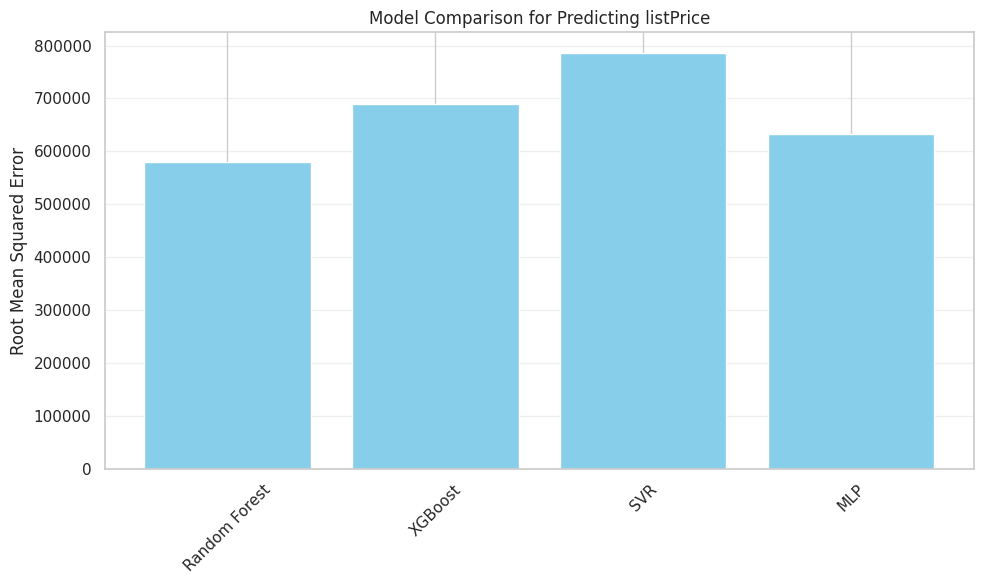

In [ ]:
target = 'listPrice'
categorical_features = ['type']
numeric_features = df_imputed_clean.drop(columns=[target] + categorical_features).select_dtypes(include=[np.number]).columns.tolist()


preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features)
])


models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "SVR" : SVR(kernel='rbf', C=100, gamma=0.1),
    "MLP": MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}


results = {}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])


    neg_rmse = cross_val_score(pipeline, df_imputed_clean.drop(columns=target), df_imputed_clean[target],
                               cv=kf, scoring="neg_root_mean_squared_error")
    results[name] = -neg_rmse.mean()


plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values(), color='skyblue')
plt.ylabel("Root Mean Squared Error")
plt.title("Model Comparison for Predicting listPrice")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [60]:
!pip install wandb

### FineTunning

In [61]:
from sklearn.model_selection import GridSearchCV
import wandb

In [ ]:
def train(config=None):
    with wandb.init(config=config, project="rf-sweep-listPrice"):
        config = wandb.config

        model = RandomForestRegressor(
            n_estimators=config.n_estimators,
            max_depth=config.max_depth,
            min_samples_split=config.min_samples_split,
            min_samples_leaf=config.min_samples_leaf,
            random_state=42,
            n_jobs=-1
        )

        pipeline = Pipeline([
            ("preprocessor", preprocessor),
            ("regressor", model)
        ])

        # Validación cruzada
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        neg_rmse = cross_val_score(
            pipeline,
            df_imputed_clean.drop(columns=target),
            df_imputed_clean[target],
            cv=kf,
            scoring="neg_root_mean_squared_error"
        )
        mean_rmse = -neg_rmse.mean()
        wandb.log({"rmse": mean_rmse})
        print(f"RMSE: {mean_rmse}")

# --- CONFIGURACIÓN DEL SWEEP ---
sweep_config = {
    "method": "bayes",
    "metric": {"name": "rmse", "goal": "minimize"},
    "parameters": {
        "n_estimators": {"min": 50, "max": 500},
        "max_depth": {"min": 5, "max": 50},
        "min_samples_split": {"min": 2, "max": 10},
        "min_samples_leaf": {"min": 1, "max": 5},
    }
}


sweep_id = wandb.sweep(sweep_config, project="rf-sweep-listPrice")
wandb.agent(sweep_id, function=train, count=50)
wandb.finish()

Create sweep with ID: 3d0inb5w
Sweep URL: https://wandb.ai/danieljimenez88m-mlops/rf-sweep-listPrice/sweeps/3d0inb5w


wandb: Agent Starting Run: kgr9xnl3 with config:
wandb: 	max_depth: 10
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 3
wandb: 	n_estimators: 278


RMSE: 559333.7119240662


rmse,▁
rmse,559333.71192


wandb: Agent Starting Run: a6lnn6ll with config:
wandb: 	max_depth: 32
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 7
wandb: 	n_estimators: 419


RMSE: 557174.4134188441


rmse,▁
rmse,557174.41342


wandb: Agent Starting Run: 297i2qb0 with config:
wandb: 	max_depth: 16
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 297


RMSE: 556143.0070664671


rmse,▁
rmse,556143.00707


wandb: Agent Starting Run: ocu6ax72 with config:
wandb: 	max_depth: 33
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 9
wandb: 	n_estimators: 395


RMSE: 558711.1979180356


rmse,▁
rmse,558711.19792


wandb: Agent Starting Run: pncatek3 with config:
wandb: 	max_depth: 35
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 168


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 555722.9521210063


rmse,▁
rmse,555722.95212


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: liy66e12 with config:
wandb: 	max_depth: 20
wandb: 	min_samples_leaf: 4
wandb: 	min_samples_split: 9
wandb: 	n_estimators: 471


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 556098.0463967253


rmse,▁
rmse,556098.0464


wandb: Agent Starting Run: 0d8pj8he with config:
wandb: 	max_depth: 50
wandb: 	min_samples_leaf: 4
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 493


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 555730.2887769913


rmse,▁
rmse,555730.28878


wandb: Agent Starting Run: jcjj3ue6 with config:
wandb: 	max_depth: 40
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 377


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 564809.3275022554


rmse,▁
rmse,564809.3275


wandb: Agent Starting Run: 2jt92ypq with config:
wandb: 	max_depth: 14
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 137


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 558423.6613560097


rmse,▁
rmse,558423.66136


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ue2038bj with config:
wandb: 	max_depth: 31
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 7
wandb: 	n_estimators: 243


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 555470.5605517944


rmse,▁
rmse,555470.56055


wandb: Agent Starting Run: 7sxaxor1 with config:
wandb: 	max_depth: 34
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 7
wandb: 	n_estimators: 102


RMSE: 560237.980178956


rmse,▁
rmse,560237.98018


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sez9fa2v with config:
wandb: 	max_depth: 16
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 397


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 571562.6201520411


rmse,▁
rmse,571562.62015


wandb: Agent Starting Run: ql6ni71l with config:
wandb: 	max_depth: 31
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 9
wandb: 	n_estimators: 248


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 555239.846806099


rmse,▁
rmse,555239.84681


wandb: Agent Starting Run: aycmw1st with config:
wandb: 	max_depth: 18
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 372


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 556317.9363617857


rmse,▁
rmse,556317.93636


wandb: Agent Starting Run: 6og115zw with config:
wandb: 	max_depth: 47
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 382


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 556651.0192077077


rmse,▁
rmse,556651.01921


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l647kwj4 with config:
wandb: 	max_depth: 28
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 468


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 557276.3309406772


rmse,▁
rmse,557276.33094


wandb: Agent Starting Run: amkv6vta with config:
wandb: 	max_depth: 20
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 9
wandb: 	n_estimators: 273


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 555960.922989777


rmse,▁
rmse,555960.92299


wandb: Agent Starting Run: u4xk56wn with config:
wandb: 	max_depth: 45
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 273


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 555907.5002777934


rmse,▁
rmse,555907.50028


wandb: Agent Starting Run: 4wmvpjus with config:
wandb: 	max_depth: 5
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 446


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 563200.8418063658


rmse,▁
rmse,563200.84181


wandb: Agent Starting Run: yaoldvtz with config:
wandb: 	max_depth: 35
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 379


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 556486.8117745136


rmse,▁
rmse,556486.81177


wandb: Agent Starting Run: 60p0cv3y with config:
wandb: 	max_depth: 15
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 131


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 555433.6587391027


rmse,▁
rmse,555433.65874


wandb: Agent Starting Run: 3av7prl8 with config:
wandb: 	max_depth: 22
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 216


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 556378.1244179871


rmse,▁
rmse,556378.12442


wandb: Agent Starting Run: oli0rp37 with config:
wandb: 	max_depth: 5
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 103


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 566016.401784536


rmse,▁
rmse,566016.40178


wandb: Agent Starting Run: 7vbehp83 with config:
wandb: 	max_depth: 24
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 68


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 562285.8604284439


rmse,▁
rmse,562285.86043


wandb: Agent Starting Run: v3hw3o6a with config:
wandb: 	max_depth: 7
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 168


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 555866.8536354917


rmse,▁
rmse,555866.85364


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 03pm0kta with config:
wandb: 	max_depth: 11
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 147


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 556074.0549587075


rmse,▁
rmse,556074.05496


wandb: Agent Starting Run: aiszrfcm with config:
wandb: 	max_depth: 13
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 191


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 556124.1185057999


rmse,▁
rmse,556124.11851


wandb: Agent Starting Run: 5ep0363w with config:
wandb: 	max_depth: 29
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 8
wandb: 	n_estimators: 333


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 556442.2743791387


rmse,▁
rmse,556442.27438


wandb: Agent Starting Run: atgwtmxw with config:
wandb: 	max_depth: 42
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 4
wandb: 	n_estimators: 485


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 556957.9371952226


rmse,▁
rmse,556957.9372


wandb: Agent Starting Run: noadi1jo with config:
wandb: 	max_depth: 34
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 266


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 555912.9944515831


rmse,▁
rmse,555912.99445


wandb: Agent Starting Run: ah2uadt4 with config:
wandb: 	max_depth: 27
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 276


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 555882.3203775784


rmse,▁
rmse,555882.32038


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j85g6c2b with config:
wandb: 	max_depth: 45
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 498


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 556907.277309984


rmse,▁
rmse,556907.27731


wandb: Agent Starting Run: cg5zfsak with config:
wandb: 	max_depth: 23
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 478


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 557089.3792617554


rmse,▁
rmse,557089.37926


wandb: Agent Starting Run: 5s9dnjfx with config:
wandb: 	max_depth: 30
wandb: 	min_samples_leaf: 4
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 244


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 553822.5461358931


rmse,▁
rmse,553822.54614


wandb: Agent Starting Run: 9hy6zkbz with config:
wandb: 	max_depth: 38
wandb: 	min_samples_leaf: 4
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 205


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 556043.241944833


rmse,▁
rmse,556043.24194


wandb: Agent Starting Run: asphy4y0 with config:
wandb: 	max_depth: 23
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 193


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 556505.0307493915


rmse,▁
rmse,556505.03075


wandb: Agent Starting Run: 9yjjiou5 with config:
wandb: 	max_depth: 30
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 310


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 556710.2125345406


rmse,▁
rmse,556710.21253


wandb: Agent Starting Run: bnuoczsn with config:
wandb: 	max_depth: 48
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 487


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 556967.7367447527


rmse,▁
rmse,556967.73674


wandb: Agent Starting Run: u01y15um with config:
wandb: 	max_depth: 24
wandb: 	min_samples_leaf: 4
wandb: 	min_samples_split: 9
wandb: 	n_estimators: 255


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 553411.7957285151


rmse,▁
rmse,553411.79573


wandb: Agent Starting Run: mi8f209o with config:
wandb: 	max_depth: 29
wandb: 	min_samples_leaf: 4
wandb: 	min_samples_split: 9
wandb: 	n_estimators: 254


RMSE: 553608.2867445204


rmse,▁
rmse,553608.28674


wandb: Agent Starting Run: 6z8huva1 with config:
wandb: 	max_depth: 24
wandb: 	min_samples_leaf: 4
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 298


RMSE: 555222.9794165634


rmse,▁
rmse,555222.97942


wandb: Agent Starting Run: bpu853pp with config:
wandb: 	max_depth: 31
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 214


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 556189.0364179092


rmse,▁
rmse,556189.03642


wandb: Agent Starting Run: 2t146e3h with config:
wandb: 	max_depth: 5
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 62


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 582448.1475260595


rmse,▁
rmse,582448.14753


wandb: Agent Starting Run: nf1t57o0 with config:
wandb: 	max_depth: 26
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 9
wandb: 	n_estimators: 257


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 555581.3786628733


rmse,▁
rmse,555581.37866


wandb: Agent Starting Run: wkbb95cd with config:
wandb: 	max_depth: 6
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 359


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 557988.4274865562


rmse,▁
rmse,557988.42749


wandb: Agent Starting Run: fibtuapw with config:
wandb: 	max_depth: 28
wandb: 	min_samples_leaf: 4
wandb: 	min_samples_split: 9
wandb: 	n_estimators: 226


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 554824.291826521


rmse,▁
rmse,554824.29183


wandb: Agent Starting Run: gk5scabf with config:
wandb: 	max_depth: 19
wandb: 	min_samples_leaf: 4
wandb: 	min_samples_split: 8
wandb: 	n_estimators: 312


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 554587.5594927237


rmse,▁
rmse,554587.55949


wandb: Agent Starting Run: 9c7ik1dy with config:
wandb: 	max_depth: 49
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 8
wandb: 	n_estimators: 375


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 556236.884132397


rmse,▁
rmse,556236.88413


wandb: Agent Starting Run: gr1kuned with config:
wandb: 	max_depth: 34
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 306


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 556477.358556198


rmse,▁
rmse,556477.35856


wandb: Agent Starting Run: oeefwdmg with config:
wandb: 	max_depth: 25
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 9
wandb: 	n_estimators: 291


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


RMSE: 555893.085189563


rmse,▁
rmse,555893.08519


In [ ]:
target = 'listPrice'
categorical_features = ['type']
numeric_features = df_imputed_clean.drop(columns=[target] + categorical_features).select_dtypes(include=[np.number]).columns.tolist()


X = df_imputed_clean.drop(columns=target)
y = df_imputed_clean[target]
X_train_full, X_test_final, y_train_full, y_test_final = train_test_split(X,
                                                                          y,
                                                                          test_size=0.25,
                                                                          random_state=42)


X_train_partial, X_val_partial, y_train_partial, y_val_partial = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42)

# Preprocesamiento
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features)
])


def train(config=None):
    with wandb.init(config=config, project="diners-random-forest"):
        config = wandb.config

        pipeline = Pipeline([
            ("preprocessor", preprocessor),
            ("random_forest", RandomForestRegressor(
                n_estimators=config.n_estimators,
                max_depth=config.max_depth,
                min_samples_split=config.min_samples_split,
                min_samples_leaf=config.min_samples_leaf,
                random_state=42
            ))
        ])


        pipeline.fit(X_train_partial, y_train_partial)
        y_pred = pipeline.predict(X_val_partial)

        rmse = np.sqrt(mean_squared_error(y_val_partial, y_pred))
        mae = mean_absolute_error(y_val_partial, y_pred)
        r2 = r2_score(y_val_partial, y_pred)

        wandb.log({
            "rmse": rmse,
            "mae": mae,
            "r2_score": r2
        })

        print(f"[Validation] RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}")


In [ ]:
sweep_config = {
    "method": "bayes",
    "metric": {"name": "rmse", "goal": "minimize"},
    "parameters": {
        "n_estimators": {"min": 50, "max": 500},
        "max_depth": {"min": 5, "max": 50},
        "min_samples_split": {"min": 2, "max": 10},
        "min_samples_leaf": {"min": 1, "max": 5},
    }
}


sweep_id = wandb.sweep(sweep_config, project="rf-sweep-listPrice")
wandb.agent(sweep_id, function=train, count=50)
wandb.finish()

Create sweep with ID: i6ps6m06
Sweep URL: https://wandb.ai/danieljimenez88m-mlops/rf-sweep-listPrice/sweeps/i6ps6m06


wandb: Agent Starting Run: 56emay8b with config:
wandb: 	max_depth: 41
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 3
wandb: 	n_estimators: 119


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


[Validation] RMSE: 436793.54, MAE: 171937.32, R²: 0.6394


mae,▁
r2_score,▁
rmse,▁
mae,171937.31653
r2_score,0.6394
rmse,436793.54025


wandb: Agent Starting Run: rtykwez6 with config:
wandb: 	max_depth: 38
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 385


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


[Validation] RMSE: 440729.92, MAE: 172068.07, R²: 0.6329


mae,▁
r2_score,▁
rmse,▁
mae,172068.07285
r2_score,0.63287
rmse,440729.9163


wandb: Agent Starting Run: uhp4lt2v with config:
wandb: 	max_depth: 27
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 129


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


[Validation] RMSE: 448553.12, MAE: 172750.02, R²: 0.6197


mae,▁
r2_score,▁
rmse,▁
mae,172750.01871
r2_score,0.61973
rmse,448553.1246


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ypdpewpn with config:
wandb: 	max_depth: 10
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 8
wandb: 	n_estimators: 280


[Validation] RMSE: 449266.26, MAE: 170301.36, R²: 0.6185


mae,▁
r2_score,▁
rmse,▁
mae,170301.3647
r2_score,0.61852
rmse,449266.25516


wandb: Agent Starting Run: 03vboj8h with config:
wandb: 	max_depth: 40
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 4
wandb: 	n_estimators: 106


[Validation] RMSE: 430386.72, MAE: 171469.88, R²: 0.6499


mae,▁
r2_score,▁
rmse,▁
mae,171469.88419
r2_score,0.6499
rmse,430386.71935


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: akqximh1 with config:
wandb: 	max_depth: 42
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 88


[Validation] RMSE: 450373.00, MAE: 172163.82, R²: 0.6166


mae,▁
r2_score,▁
rmse,▁
mae,172163.8196
r2_score,0.61663
rmse,450372.99504


wandb: Agent Starting Run: oo3c53qf with config:
wandb: 	max_depth: 36
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 7
wandb: 	n_estimators: 385


[Validation] RMSE: 443681.29, MAE: 172707.46, R²: 0.6279


mae,▁
r2_score,▁
rmse,▁
mae,172707.46263
r2_score,0.62794
rmse,443681.29488


wandb: Agent Starting Run: th0oiuan with config:
wandb: 	max_depth: 30
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 480


[Validation] RMSE: 438964.04, MAE: 171880.04, R²: 0.6358


mae,▁
r2_score,▁
rmse,▁
mae,171880.0432
r2_score,0.63581
rmse,438964.04109


wandb: Agent Starting Run: 9rnyy890 with config:
wandb: 	max_depth: 37
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 8
wandb: 	n_estimators: 408


[Validation] RMSE: 447243.03, MAE: 173090.17, R²: 0.6219


mae,▁
r2_score,▁
rmse,▁
mae,173090.17331
r2_score,0.62194
rmse,447243.0278


wandb: Agent Starting Run: ds7g1a2g with config:
wandb: 	max_depth: 43
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 9
wandb: 	n_estimators: 181


[Validation] RMSE: 452192.88, MAE: 173138.78, R²: 0.6135


mae,▁
r2_score,▁
rmse,▁
mae,173138.78151
r2_score,0.61353
rmse,452192.88163


wandb: Agent Starting Run: gu0awjc5 with config:
wandb: 	max_depth: 40
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 4
wandb: 	n_estimators: 67


[Validation] RMSE: 437207.98, MAE: 170678.32, R²: 0.6387


mae,▁
r2_score,▁
rmse,▁
mae,170678.3156
r2_score,0.63872
rmse,437207.97861


wandb: Agent Starting Run: dv7fxnsy with config:
wandb: 	max_depth: 44
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 115


[Validation] RMSE: 442480.57, MAE: 172799.67, R²: 0.6300


mae,▁
r2_score,▁
rmse,▁
mae,172799.67493
r2_score,0.62995
rmse,442480.57184


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mh2iqamv with config:
wandb: 	max_depth: 37
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 7
wandb: 	n_estimators: 137


[Validation] RMSE: 456737.98, MAE: 175032.44, R²: 0.6057


mae,▁
r2_score,▁
rmse,▁
mae,175032.44096
r2_score,0.60572
rmse,456737.97966


wandb: Agent Starting Run: 11dfb55c with config:
wandb: 	max_depth: 32
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 4
wandb: 	n_estimators: 93


[Validation] RMSE: 430439.69, MAE: 170824.19, R²: 0.6498


mae,▁
r2_score,▁
rmse,▁
mae,170824.18664
r2_score,0.64982
rmse,430439.68705


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vtx7cs98 with config:
wandb: 	max_depth: 37
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 3
wandb: 	n_estimators: 105


[Validation] RMSE: 431051.07, MAE: 171580.43, R²: 0.6488


mae,▁
r2_score,▁
rmse,▁
mae,171580.42894
r2_score,0.64882
rmse,431051.07346


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bvg364us with config:
wandb: 	max_depth: 39
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 4
wandb: 	n_estimators: 175


[Validation] RMSE: 432214.49, MAE: 171040.78, R²: 0.6469


mae,▁
r2_score,▁
rmse,▁
mae,171040.78181
r2_score,0.64692
rmse,432214.49384


wandb: Agent Starting Run: j8u3j0nv with config:
wandb: 	max_depth: 31
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 4
wandb: 	n_estimators: 148


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


[Validation] RMSE: 428915.46, MAE: 170799.19, R²: 0.6523


mae,▁
r2_score,▁
rmse,▁
mae,170799.18862
r2_score,0.65229
rmse,428915.45726


wandb: Agent Starting Run: 0ejen7w4 with config:
wandb: 	max_depth: 31
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 4
wandb: 	n_estimators: 174


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


[Validation] RMSE: 432486.35, MAE: 171257.24, R²: 0.6465


mae,▁
r2_score,▁
rmse,▁
mae,171257.24486
r2_score,0.64648
rmse,432486.35172


wandb: Agent Starting Run: aos9qwwd with config:
wandb: 	max_depth: 21
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 99


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


[Validation] RMSE: 430471.10, MAE: 171293.42, R²: 0.6498


mae,▁
r2_score,▁
rmse,▁
mae,171293.41511
r2_score,0.64977
rmse,430471.10453


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hstgu7xo with config:
wandb: 	max_depth: 30
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 150


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


[Validation] RMSE: 428105.42, MAE: 170393.64, R²: 0.6536


mae,▁
r2_score,▁
rmse,▁
mae,170393.63624
r2_score,0.65361
rmse,428105.42477


wandb: Agent Starting Run: o6k5vg02 with config:
wandb: 	max_depth: 25
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 3
wandb: 	n_estimators: 127


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


[Validation] RMSE: 430674.35, MAE: 170135.53, R²: 0.6494


mae,▁
r2_score,▁
rmse,▁
mae,170135.53232
r2_score,0.64944
rmse,430674.35307


wandb: Agent Starting Run: vfhybyfu with config:
wandb: 	max_depth: 28
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 212


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


[Validation] RMSE: 431497.10, MAE: 170730.67, R²: 0.6481


mae,▁
r2_score,▁
rmse,▁
mae,170730.67372
r2_score,0.6481
rmse,431497.10353


wandb: Agent Starting Run: agnj5rlu with config:
wandb: 	max_depth: 29
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 3
wandb: 	n_estimators: 127


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


[Validation] RMSE: 433684.81, MAE: 170730.20, R²: 0.6445


mae,▁
r2_score,▁
rmse,▁
mae,170730.20206
r2_score,0.64452
rmse,433684.8091


wandb: Agent Starting Run: 8un7lo9k with config:
wandb: 	max_depth: 24
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 154


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


[Validation] RMSE: 426848.90, MAE: 170243.89, R²: 0.6556


mae,▁
r2_score,▁
rmse,▁
mae,170243.8937
r2_score,0.65564
rmse,426848.90474


wandb: Agent Starting Run: pds9udwh with config:
wandb: 	max_depth: 25
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 3
wandb: 	n_estimators: 159


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


[Validation] RMSE: 429086.47, MAE: 169862.44, R²: 0.6520


mae,▁
r2_score,▁
rmse,▁
mae,169862.43889
r2_score,0.65202
rmse,429086.47219


wandb: Agent Starting Run: hq7jng56 with config:
wandb: 	max_depth: 23
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 3
wandb: 	n_estimators: 156


[Validation] RMSE: 429275.22, MAE: 169965.35, R²: 0.6517


mae,▁
r2_score,▁
rmse,▁
mae,169965.35257
r2_score,0.65171
rmse,429275.2216


wandb: Agent Starting Run: laz5aqiv with config:
wandb: 	max_depth: 27
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 140


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


[Validation] RMSE: 432331.62, MAE: 170685.52, R²: 0.6467


mae,▁
r2_score,▁
rmse,▁
mae,170685.51929
r2_score,0.64673
rmse,432331.62498


wandb: Agent Starting Run: hecwewmq with config:
wandb: 	max_depth: 38
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 164


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


[Validation] RMSE: 448060.40, MAE: 172329.02, R²: 0.6206


mae,▁
r2_score,▁
rmse,▁
mae,172329.02061
r2_score,0.62056
rmse,448060.40152


wandb: Agent Starting Run: mmrgllof with config:
wandb: 	max_depth: 25
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 195


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


[Validation] RMSE: 428981.42, MAE: 170185.32, R²: 0.6522


mae,▁
r2_score,▁
rmse,▁
mae,170185.31856
r2_score,0.65219
rmse,428981.41761


wandb: Agent Starting Run: wj4c527m with config:
wandb: 	max_depth: 18
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 159


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


[Validation] RMSE: 430557.23, MAE: 169812.32, R²: 0.6496


mae,▁
r2_score,▁
rmse,▁
mae,169812.32412
r2_score,0.64963
rmse,430557.23329


wandb: Agent Starting Run: nbgimzze with config:
wandb: 	max_depth: 24
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 198


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


[Validation] RMSE: 425235.77, MAE: 170397.32, R²: 0.6582


mae,▁
r2_score,▁
rmse,▁
mae,170397.31701
r2_score,0.65823
rmse,425235.76974


wandb: Agent Starting Run: 312qj1iv with config:
wandb: 	max_depth: 20
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 263


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


[Validation] RMSE: 436726.24, MAE: 171352.40, R²: 0.6395


mae,▁
r2_score,▁
rmse,▁
mae,171352.40049
r2_score,0.63951
rmse,436726.2372


wandb: Agent Starting Run: tzmshtvs with config:
wandb: 	max_depth: 23
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 150


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


[Validation] RMSE: 428446.36, MAE: 170221.08, R²: 0.6531


mae,▁
r2_score,▁
rmse,▁
mae,170221.08359
r2_score,0.65305
rmse,428446.36053


wandb: Agent Starting Run: 1wkq72gs with config:
wandb: 	max_depth: 22
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 3
wandb: 	n_estimators: 191


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


[Validation] RMSE: 431417.02, MAE: 170353.18, R²: 0.6482


mae,▁
r2_score,▁
rmse,▁
mae,170353.17621
r2_score,0.64823
rmse,431417.02173


wandb: Agent Starting Run: c9efy53e with config:
wandb: 	max_depth: 26
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 169


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


[Validation] RMSE: 428012.45, MAE: 170155.93, R²: 0.6538


mae,▁
r2_score,▁
rmse,▁
mae,170155.92738
r2_score,0.65376
rmse,428012.45135


wandb: Agent Starting Run: n6r185nn with config:
wandb: 	max_depth: 32
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 3
wandb: 	n_estimators: 159


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


[Validation] RMSE: 431104.68, MAE: 170561.02, R²: 0.6487


mae,▁
r2_score,▁
rmse,▁
mae,170561.0157
r2_score,0.64874
rmse,431104.67992


wandb: Agent Starting Run: 47xjg9bj with config:
wandb: 	max_depth: 23
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 174


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


[Validation] RMSE: 433404.50, MAE: 170836.12, R²: 0.6450


mae,▁
r2_score,▁
rmse,▁
mae,170836.11943
r2_score,0.64498
rmse,433404.50157


wandb: Agent Starting Run: po0ycf3y with config:
wandb: 	max_depth: 38
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 8
wandb: 	n_estimators: 454


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


[Validation] RMSE: 444674.29, MAE: 172577.73, R²: 0.6263


mae,▁
r2_score,▁
rmse,▁
mae,172577.72631
r2_score,0.62627
rmse,444674.28829


wandb: Agent Starting Run: kf3fuczg with config:
wandb: 	max_depth: 6
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 3
wandb: 	n_estimators: 223


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


[Validation] RMSE: 453437.14, MAE: 179289.71, R²: 0.6114


mae,▁
r2_score,▁
rmse,▁
mae,179289.71497
r2_score,0.6114
rmse,453437.13617


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c9d33umg with config:
wandb: 	max_depth: 14
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 3
wandb: 	n_estimators: 137


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


[Validation] RMSE: 444242.73, MAE: 170894.65, R²: 0.6270


mae,▁
r2_score,▁
rmse,▁
mae,170894.65494
r2_score,0.627
rmse,444242.73466


wandb: Agent Starting Run: uvd09m33 with config:
wandb: 	max_depth: 45
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 349


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


[Validation] RMSE: 454805.81, MAE: 173036.95, R²: 0.6091


mae,▁
r2_score,▁
rmse,▁
mae,173036.95115
r2_score,0.60905
rmse,454805.80506


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: aqiq5lgn with config:
wandb: 	max_depth: 38
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 323


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


[Validation] RMSE: 444737.92, MAE: 171607.38, R²: 0.6262


mae,▁
r2_score,▁
rmse,▁
mae,171607.37712
r2_score,0.62617
rmse,444737.91549


wandb: Agent Starting Run: 645gqof4 with config:
wandb: 	max_depth: 43
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 212


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


[Validation] RMSE: 438069.48, MAE: 171357.82, R²: 0.6373


mae,▁
r2_score,▁
rmse,▁
mae,171357.82096
r2_score,0.63729
rmse,438069.48236


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5pvjadgd with config:
wandb: 	max_depth: 26
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 7
wandb: 	n_estimators: 270


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


[Validation] RMSE: 447210.58, MAE: 172200.17, R²: 0.6220


mae,▁
r2_score,▁
rmse,▁
mae,172200.16775
r2_score,0.622
rmse,447210.58312


wandb: Agent Starting Run: 6dyc8zfd with config:
wandb: 	max_depth: 37
wandb: 	min_samples_leaf: 4
wandb: 	min_samples_split: 3
wandb: 	n_estimators: 128


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


[Validation] RMSE: 453077.95, MAE: 174068.33, R²: 0.6120


mae,▁
r2_score,▁
rmse,▁
mae,174068.32551
r2_score,0.61202
rmse,453077.95332


wandb: Agent Starting Run: vbpdjrrq with config:
wandb: 	max_depth: 43
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 231


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


[Validation] RMSE: 432573.73, MAE: 171092.28, R²: 0.6463


mae,▁
r2_score,▁
rmse,▁
mae,171092.28172
r2_score,0.64634
rmse,432573.72658


wandb: Agent Starting Run: p1r2mi98 with config:
wandb: 	max_depth: 45
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 70


/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


[Validation] RMSE: 450002.31, MAE: 173389.02, R²: 0.6173


mae,▁
r2_score,▁
rmse,▁
mae,173389.01842
r2_score,0.61726
rmse,450002.31293


wandb: Agent Starting Run: w1t5r571 with config:
wandb: 	max_depth: 39
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 289


[Validation] RMSE: 455521.10, MAE: 174309.89, R²: 0.6078


mae,▁
r2_score,▁
rmse,▁
mae,174309.89042
r2_score,0.60782
rmse,455521.1016


wandb: Agent Starting Run: cf8wvkv8 with config:
wandb: 	max_depth: 32
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 3
wandb: 	n_estimators: 141


[Validation] RMSE: 430028.72, MAE: 170755.44, R²: 0.6505


mae,▁
r2_score,▁
rmse,▁
mae,170755.43954
r2_score,0.65049
rmse,430028.71936


wandb: Agent Starting Run: 3tf1zmw0 with config:
wandb: 	max_depth: 33
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 116


[Validation] RMSE: 442327.24, MAE: 172784.17, R²: 0.6302


mae,▁
r2_score,▁
rmse,▁
mae,172784.16846
r2_score,0.63021
rmse,442327.2426


### Testing

In [68]:
df_imputed_clean["listPrice_log"] = np.log1p(df_imputed_clean["listPrice"])
target = 'listPrice_log'
categorical_features = ['type']
numeric_features = df_imputed_clean.drop(columns=[target] + categorical_features).select_dtypes(include=[np.number]).columns.tolist()

X = df_imputed_clean.drop(columns=target)
y = df_imputed_clean[target]
X_train_full, X_test_final, y_train_full, y_test_final = train_test_split(X,
                                                                          y,
                                                                          test_size=0.25,
                                                                          random_state=42)


X_train_partial, X_val_partial, y_train_partial, y_val_partial = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42)


preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features)
])



sweep_config = {
    "method": "bayes",
    "metric": {"name": "rmse", "goal": "minimize"},
    "parameters": {
        "n_estimators": {"min": 100, "max": 300},
        "max_depth": {"min": 5, "max": 20},
        "min_samples_split": {"min": 4, "max": 10},
        "min_samples_leaf": {"min": 2, "max": 10},
        "max_features": {
            "values": ["sqrt", "log2", 0.5]
        }
    }
}


from sklearn.model_selection import cross_val_score

def train(config=None):
    with wandb.init(config=config,
                    project="rf-sweep-listPrice2"):
        config = wandb.config

        pipeline = Pipeline([
            ("preprocessor", preprocessor),
            ("random_forest", RandomForestRegressor(
                n_estimators=config.n_estimators,
                max_depth=config.max_depth,
                min_samples_split=config.min_samples_split,
                min_samples_leaf=config.min_samples_leaf,
                max_features=config.max_features,
                random_state=42,
                n_jobs=-1
            ))
        ])


        scores_rmse = -cross_val_score(
            pipeline, X_train_full, y_train_full,
            scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1
        )

        scores_r2 = cross_val_score(
            pipeline, X_train_full, y_train_full,
            scoring="r2", cv=5, n_jobs=-1
        )

        wandb.log({
            "cv_rmse_mean": scores_rmse.mean(),
            "cv_rmse_std": scores_rmse.std(),
            "cv_r2_mean": scores_r2.mean(),
            "cv_r2_std": scores_r2.std()
        })

        print(f"[CV] RMSE: {scores_rmse.mean():.2f} ± {scores_rmse.std():.2f}, R²: {scores_r2.mean():.4f}")


In [69]:
sweep_id = wandb.sweep(sweep_config, project="rf-sweep-listPrice2")
wandb.agent(sweep_id, function=train, count=50)
wandb.finish()

Create sweep with ID: 1beg82a4
Sweep URL: https://wandb.ai/danieljimenez88m-mlops/rf-sweep-listPrice2/sweeps/1beg82a4


wandb: Agent Starting Run: t7zy10gx with config:
wandb: 	max_depth: 7
wandb: 	max_features: 0.5
wandb: 	min_samples_leaf: 6
wandb: 	min_samples_split: 9
wandb: 	n_estimators: 284


[CV] RMSE: 0.23 ± 0.12, R²: 0.9443


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.94434
cv_r2_std,0.03884
cv_rmse_mean,0.22687
cv_rmse_std,0.11613


wandb: Agent Starting Run: iuh9bz9p with config:
wandb: 	max_depth: 6
wandb: 	max_features: 0.5
wandb: 	min_samples_leaf: 10
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 114


[CV] RMSE: 0.26 ± 0.12, R²: 0.9305


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.9305
cv_r2_std,0.04582
cv_rmse_mean,0.2567
cv_rmse_std,0.1219


wandb: Agent Starting Run: bvhsvpwm with config:
wandb: 	max_depth: 20
wandb: 	max_features: sqrt
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 182


[CV] RMSE: 0.34 ± 0.11, R²: 0.8894


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.88938
cv_r2_std,0.04991
cv_rmse_mean,0.33682
cv_rmse_std,0.10664


wandb: Agent Starting Run: fggw89g1 with config:
wandb: 	max_depth: 6
wandb: 	max_features: sqrt
wandb: 	min_samples_leaf: 7
wandb: 	min_samples_split: 7
wandb: 	n_estimators: 212


[CV] RMSE: 0.43 ± 0.10, R²: 0.8260


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.82598
cv_r2_std,0.05602
cv_rmse_mean,0.42676
cv_rmse_std,0.10264


wandb: Agent Starting Run: n1cc4n5q with config:
wandb: 	max_depth: 18
wandb: 	max_features: log2
wandb: 	min_samples_leaf: 10
wandb: 	min_samples_split: 7
wandb: 	n_estimators: 130


[CV] RMSE: 0.39 ± 0.12, R²: 0.8511


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.85109
cv_r2_std,0.06383
cv_rmse_mean,0.39169
cv_rmse_std,0.11836


wandb: Agent Starting Run: zxvlb4gu with config:
wandb: 	max_depth: 12
wandb: 	max_features: log2
wandb: 	min_samples_leaf: 8
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 136


[CV] RMSE: 0.38 ± 0.12, R²: 0.8590


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.85899
cv_r2_std,0.06089
cv_rmse_mean,0.38105
cv_rmse_std,0.11602


wandb: Agent Starting Run: ugsc4d6v with config:
wandb: 	max_depth: 19
wandb: 	max_features: log2
wandb: 	min_samples_leaf: 6
wandb: 	min_samples_split: 9
wandb: 	n_estimators: 299


[CV] RMSE: 0.37 ± 0.11, R²: 0.8676


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.8676
cv_r2_std,0.0578
cv_rmse_mean,0.36909
cv_rmse_std,0.11322


wandb: Agent Starting Run: djcce23z with config:
wandb: 	max_depth: 15
wandb: 	max_features: log2
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 4
wandb: 	n_estimators: 249


[CV] RMSE: 0.32 ± 0.10, R²: 0.9022


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.90221
cv_r2_std,0.04575
cv_rmse_mean,0.31618
cv_rmse_std,0.10255


wandb: Agent Starting Run: cx1fkhjq with config:
wandb: 	max_depth: 13
wandb: 	max_features: 0.5
wandb: 	min_samples_leaf: 4
wandb: 	min_samples_split: 8
wandb: 	n_estimators: 142


[CV] RMSE: 0.20 ± 0.11, R²: 0.9541


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.95408
cv_r2_std,0.0328
cv_rmse_mean,0.20462
cv_rmse_std,0.1087


wandb: Agent Starting Run: wbuyaqj2 with config:
wandb: 	max_depth: 17
wandb: 	max_features: log2
wandb: 	min_samples_leaf: 10
wandb: 	min_samples_split: 9
wandb: 	n_estimators: 265


[CV] RMSE: 0.39 ± 0.12, R²: 0.8503


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.85025
cv_r2_std,0.0625
cv_rmse_mean,0.39324
cv_rmse_std,0.11625


wandb: Agent Starting Run: l7h3vqpe with config:
wandb: 	max_depth: 7
wandb: 	max_features: 0.5
wandb: 	min_samples_leaf: 8
wandb: 	min_samples_split: 4
wandb: 	n_estimators: 228


[CV] RMSE: 0.24 ± 0.13, R²: 0.9365


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.93653
cv_r2_std,0.04451
cv_rmse_mean,0.24181
cv_rmse_std,0.12518


wandb: Agent Starting Run: 1yylrx7p with config:
wandb: 	max_depth: 10
wandb: 	max_features: 0.5
wandb: 	min_samples_leaf: 6
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 153


[CV] RMSE: 0.22 ± 0.12, R²: 0.9477


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.94768
cv_r2_std,0.03863
cv_rmse_mean,0.21592
cv_rmse_std,0.12143


wandb: Agent Starting Run: uvwx52vo with config:
wandb: 	max_depth: 8
wandb: 	max_features: log2
wandb: 	min_samples_leaf: 7
wandb: 	min_samples_split: 7
wandb: 	n_estimators: 271


[CV] RMSE: 0.40 ± 0.11, R²: 0.8482


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.84825
cv_r2_std,0.05784
cv_rmse_mean,0.39703
cv_rmse_std,0.10869


wandb: Agent Starting Run: u5zadte6 with config:
wandb: 	max_depth: 16
wandb: 	max_features: sqrt
wandb: 	min_samples_leaf: 10
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 211


[CV] RMSE: 0.39 ± 0.12, R²: 0.8515


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.85149
cv_r2_std,0.06245
cv_rmse_mean,0.3915
cv_rmse_std,0.11652


wandb: Agent Starting Run: 8tc1szf2 with config:
wandb: 	max_depth: 14
wandb: 	max_features: log2
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 4
wandb: 	n_estimators: 203


[CV] RMSE: 0.33 ± 0.11, R²: 0.8903


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.89031
cv_r2_std,0.05092
cv_rmse_mean,0.33493
cv_rmse_std,0.10872


wandb: Agent Starting Run: 9zmwfusl with config:
wandb: 	max_depth: 13
wandb: 	max_features: 0.5
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 134


[CV] RMSE: 0.17 ± 0.09, R²: 0.9677


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.96771
cv_r2_std,0.02228
cv_rmse_mean,0.17337
cv_rmse_std,0.08637


wandb: Agent Starting Run: tgppf2pv with config:
wandb: 	max_depth: 14
wandb: 	max_features: sqrt
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 8
wandb: 	n_estimators: 157


[CV] RMSE: 0.36 ± 0.11, R²: 0.8730


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.87297
cv_r2_std,0.05567
cv_rmse_mean,0.36144
cv_rmse_std,0.11086


wandb: Agent Starting Run: 0opw1h4s with config:
wandb: 	max_depth: 15
wandb: 	max_features: sqrt
wandb: 	min_samples_leaf: 6
wandb: 	min_samples_split: 7
wandb: 	n_estimators: 154


[CV] RMSE: 0.37 ± 0.11, R²: 0.8662


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.86624
cv_r2_std,0.05587
cv_rmse_mean,0.3716
cv_rmse_std,0.10976


wandb: Agent Starting Run: xcpgmuzd with config:
wandb: 	max_depth: 16
wandb: 	max_features: 0.5
wandb: 	min_samples_leaf: 8
wandb: 	min_samples_split: 4
wandb: 	n_estimators: 162


[CV] RMSE: 0.23 ± 0.13, R²: 0.9399


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.93995
cv_r2_std,0.04371
cv_rmse_mean,0.23234
cv_rmse_std,0.12826


wandb: Agent Starting Run: qx3a8fhf with config:
wandb: 	max_depth: 6
wandb: 	max_features: log2
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 9
wandb: 	n_estimators: 241


[CV] RMSE: 0.40 ± 0.08, R²: 0.8448


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.84478
cv_r2_std,0.04121
cv_rmse_mean,0.40401
cv_rmse_std,0.08475


wandb: Agent Starting Run: ajhh5bgh with config:
wandb: 	max_depth: 13
wandb: 	max_features: log2
wandb: 	min_samples_leaf: 7
wandb: 	min_samples_split: 7
wandb: 	n_estimators: 175


[CV] RMSE: 0.38 ± 0.11, R²: 0.8635


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.86351
cv_r2_std,0.05593
cv_rmse_mean,0.37564
cv_rmse_std,0.10922


wandb: Agent Starting Run: oni0ogp0 with config:
wandb: 	max_depth: 19
wandb: 	max_features: sqrt
wandb: 	min_samples_leaf: 6
wandb: 	min_samples_split: 9
wandb: 	n_estimators: 208


[CV] RMSE: 0.37 ± 0.11, R²: 0.8683


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.86834
cv_r2_std,0.05688
cv_rmse_mean,0.36821
cv_rmse_std,0.11197


wandb: Agent Starting Run: ytfgwsji with config:
wandb: 	max_depth: 6
wandb: 	max_features: sqrt
wandb: 	min_samples_leaf: 7
wandb: 	min_samples_split: 4
wandb: 	n_estimators: 282


[CV] RMSE: 0.43 ± 0.10, R²: 0.8255


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.82549
cv_r2_std,0.0562
cv_rmse_mean,0.42735
cv_rmse_std,0.10281


wandb: Agent Starting Run: p111nvqv with config:
wandb: 	max_depth: 6
wandb: 	max_features: log2
wandb: 	min_samples_leaf: 6
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 217


[CV] RMSE: 0.43 ± 0.10, R²: 0.8264


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.82639
cv_r2_std,0.05501
cv_rmse_mean,0.42634
cv_rmse_std,0.10121


wandb: Agent Starting Run: 8h8jw1vz with config:
wandb: 	max_depth: 7
wandb: 	max_features: sqrt
wandb: 	min_samples_leaf: 7
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 246


[CV] RMSE: 0.41 ± 0.11, R²: 0.8392


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.83918
cv_r2_std,0.05703
cv_rmse_mean,0.40948
cv_rmse_std,0.10594


wandb: Agent Starting Run: gjt6swie with config:
wandb: 	max_depth: 5
wandb: 	max_features: sqrt
wandb: 	min_samples_leaf: 4
wandb: 	min_samples_split: 7
wandb: 	n_estimators: 266


[CV] RMSE: 0.45 ± 0.09, R²: 0.8088


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.80877
cv_r2_std,0.04742
cv_rmse_mean,0.44876
cv_rmse_std,0.09058


wandb: Agent Starting Run: 0q1gdhor with config:
wandb: 	max_depth: 13
wandb: 	max_features: sqrt
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 178


[CV] RMSE: 0.32 ± 0.10, R²: 0.9007


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.90067
cv_r2_std,0.04504
cv_rmse_mean,0.31916
cv_rmse_std,0.10034


wandb: Agent Starting Run: 3gvkgff0 with config:
wandb: 	max_depth: 13
wandb: 	max_features: sqrt
wandb: 	min_samples_leaf: 10
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 183


[CV] RMSE: 0.39 ± 0.12, R²: 0.8534


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.85341
cv_r2_std,0.06228
cv_rmse_mean,0.38876
cv_rmse_std,0.11663


wandb: Agent Starting Run: w9g0c6bw with config:
wandb: 	max_depth: 7
wandb: 	max_features: 0.5
wandb: 	min_samples_leaf: 4
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 278


[CV] RMSE: 0.21 ± 0.11, R²: 0.9511


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.9511
cv_r2_std,0.03364
cv_rmse_mean,0.21347
cv_rmse_std,0.10696


wandb: Agent Starting Run: 9a7963b4 with config:
wandb: 	max_depth: 15
wandb: 	max_features: sqrt
wandb: 	min_samples_leaf: 6
wandb: 	min_samples_split: 8
wandb: 	n_estimators: 175


[CV] RMSE: 0.37 ± 0.11, R²: 0.8685


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.86852
cv_r2_std,0.05615
cv_rmse_mean,0.3681
cv_rmse_std,0.11072


wandb: Agent Starting Run: wexhv27k with config:
wandb: 	max_depth: 10
wandb: 	max_features: sqrt
wandb: 	min_samples_leaf: 6
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 298


[CV] RMSE: 0.38 ± 0.11, R²: 0.8635


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.86346
cv_r2_std,0.05739
cv_rmse_mean,0.37541
cv_rmse_std,0.11128


wandb: Agent Starting Run: 6nicp7yj with config:
wandb: 	max_depth: 19
wandb: 	max_features: sqrt
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 4
wandb: 	n_estimators: 140


[CV] RMSE: 0.36 ± 0.11, R²: 0.8746


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.87457
cv_r2_std,0.05581
cv_rmse_mean,0.3589
cv_rmse_std,0.11156


wandb: Agent Starting Run: rt0czdlv with config:
wandb: 	max_depth: 20
wandb: 	max_features: sqrt
wandb: 	min_samples_leaf: 7
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 161


[CV] RMSE: 0.37 ± 0.11, R²: 0.8645


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.86446
cv_r2_std,0.05699
cv_rmse_mean,0.37398
cv_rmse_std,0.11101


wandb: Agent Starting Run: tml7gx57 with config:
wandb: 	max_depth: 12
wandb: 	max_features: 0.5
wandb: 	min_samples_leaf: 9
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 195


[CV] RMSE: 0.24 ± 0.13, R²: 0.9371


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.93715
cv_r2_std,0.04534
cv_rmse_mean,0.23837
cv_rmse_std,0.12966


wandb: Agent Starting Run: e36azgpc with config:
wandb: 	max_depth: 6
wandb: 	max_features: log2
wandb: 	min_samples_leaf: 8
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 166


[CV] RMSE: 0.43 ± 0.10, R²: 0.8195


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.81946
cv_r2_std,0.05683
cv_rmse_mean,0.43472
cv_rmse_std,0.10289


wandb: Agent Starting Run: qsef0rri with config:
wandb: 	max_depth: 19
wandb: 	max_features: sqrt
wandb: 	min_samples_leaf: 4
wandb: 	min_samples_split: 9
wandb: 	n_estimators: 221


[CV] RMSE: 0.35 ± 0.11, R²: 0.8793


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.87932
cv_r2_std,0.0553
cv_rmse_mean,0.35156
cv_rmse_std,0.11282


wandb: Agent Starting Run: qlm6eqz6 with config:
wandb: 	max_depth: 20
wandb: 	max_features: sqrt
wandb: 	min_samples_leaf: 7
wandb: 	min_samples_split: 8
wandb: 	n_estimators: 265


[CV] RMSE: 0.38 ± 0.11, R²: 0.8633


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.86329
cv_r2_std,0.05833
cv_rmse_mean,0.37538
cv_rmse_std,0.11291


wandb: Agent Starting Run: qztuncs0 with config:
wandb: 	max_depth: 15
wandb: 	max_features: 0.5
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 168


[CV] RMSE: 0.21 ± 0.12, R²: 0.9492


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.94919
cv_r2_std,0.03755
cv_rmse_mean,0.21281
cv_rmse_std,0.11974


wandb: Agent Starting Run: 46h03zs7 with config:
wandb: 	max_depth: 6
wandb: 	max_features: 0.5
wandb: 	min_samples_leaf: 10
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 279


[CV] RMSE: 0.26 ± 0.12, R²: 0.9300


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.92995
cv_r2_std,0.04689
cv_rmse_mean,0.25694
cv_rmse_std,0.12425


wandb: Agent Starting Run: j1a3gb5p with config:
wandb: 	max_depth: 20
wandb: 	max_features: 0.5
wandb: 	min_samples_leaf: 10
wandb: 	min_samples_split: 7
wandb: 	n_estimators: 254


[CV] RMSE: 0.24 ± 0.13, R²: 0.9362


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.93622
cv_r2_std,0.04611
cv_rmse_mean,0.24008
cv_rmse_std,0.13066


wandb: Agent Starting Run: kq2dzzfh with config:
wandb: 	max_depth: 19
wandb: 	max_features: sqrt
wandb: 	min_samples_leaf: 10
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 114


[CV] RMSE: 0.39 ± 0.12, R²: 0.8519


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.85194
cv_r2_std,0.06311
cv_rmse_mean,0.39067
cv_rmse_std,0.11757


wandb: Agent Starting Run: m8fpyekb with config:
wandb: 	max_depth: 17
wandb: 	max_features: sqrt
wandb: 	min_samples_leaf: 10
wandb: 	min_samples_split: 4
wandb: 	n_estimators: 140


[CV] RMSE: 0.39 ± 0.12, R²: 0.8513


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.85127
cv_r2_std,0.0628
cv_rmse_mean,0.39169
cv_rmse_std,0.11695


wandb: Agent Starting Run: t971zjmh with config:
wandb: 	max_depth: 16
wandb: 	max_features: sqrt
wandb: 	min_samples_leaf: 6
wandb: 	min_samples_split: 9
wandb: 	n_estimators: 200


[CV] RMSE: 0.37 ± 0.11, R²: 0.8689


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.86891
cv_r2_std,0.0563
cv_rmse_mean,0.36747
cv_rmse_std,0.11113


wandb: Agent Starting Run: avtqb03d with config:
wandb: 	max_depth: 8
wandb: 	max_features: log2
wandb: 	min_samples_leaf: 8
wandb: 	min_samples_split: 8
wandb: 	n_estimators: 272


[CV] RMSE: 0.40 ± 0.11, R²: 0.8453


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.8453
cv_r2_std,0.05902
cv_rmse_mean,0.40084
cv_rmse_std,0.10996


wandb: Agent Starting Run: py45030v with config:
wandb: 	max_depth: 17
wandb: 	max_features: 0.5
wandb: 	min_samples_leaf: 8
wandb: 	min_samples_split: 8
wandb: 	n_estimators: 180


[CV] RMSE: 0.23 ± 0.13, R²: 0.9403


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.94033
cv_r2_std,0.04341
cv_rmse_mean,0.2316
cv_rmse_std,0.12778


wandb: Agent Starting Run: evakqzrq with config:
wandb: 	max_depth: 15
wandb: 	max_features: sqrt
wandb: 	min_samples_leaf: 9
wandb: 	min_samples_split: 9
wandb: 	n_estimators: 174


[CV] RMSE: 0.39 ± 0.11, R²: 0.8534


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.85343
cv_r2_std,0.06078
cv_rmse_mean,0.38912
cv_rmse_std,0.11431


wandb: Agent Starting Run: xaodd2c9 with config:
wandb: 	max_depth: 17
wandb: 	max_features: sqrt
wandb: 	min_samples_leaf: 7
wandb: 	min_samples_split: 4
wandb: 	n_estimators: 105


[CV] RMSE: 0.37 ± 0.11, R²: 0.8657


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.86567
cv_r2_std,0.05659
cv_rmse_mean,0.37232
cv_rmse_std,0.11123


wandb: Agent Starting Run: hj0jf0kb with config:
wandb: 	max_depth: 16
wandb: 	max_features: sqrt
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 5
wandb: 	n_estimators: 132


[CV] RMSE: 0.31 ± 0.10, R²: 0.9034


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.90343
cv_r2_std,0.04527
cv_rmse_mean,0.31414
cv_rmse_std,0.10204


wandb: Agent Starting Run: f4j3tmpy with config:
wandb: 	max_depth: 14
wandb: 	max_features: 0.5
wandb: 	min_samples_leaf: 10
wandb: 	min_samples_split: 8
wandb: 	n_estimators: 181


[CV] RMSE: 0.24 ± 0.13, R²: 0.9356


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.93559
cv_r2_std,0.04629
cv_rmse_mean,0.24171
cv_rmse_std,0.13035


wandb: Agent Starting Run: zxze581b with config:
wandb: 	max_depth: 18
wandb: 	max_features: sqrt
wandb: 	min_samples_leaf: 8
wandb: 	min_samples_split: 8
wandb: 	n_estimators: 259


[CV] RMSE: 0.38 ± 0.12, R²: 0.8582


cv_r2_mean,▁
cv_r2_std,▁
cv_rmse_mean,▁
cv_rmse_std,▁
cv_r2_mean,0.85821
cv_r2_std,0.0615
cv_rmse_mean,0.382
cv_rmse_std,0.11682


In [70]:
api = wandb.Api()
sweep = api.sweep("danieljimenez88m-mlops/rf-sweep-listPrice2/" + sweep_id)


best_run = min(sweep.runs, key=lambda run: run.summary.get("cv_rmse_mean", float('inf')))
best_config = best_run.config

print("🏆 Mejores hiperparámetros encontrados:")
for k, v in best_config.items():
    print(f"{k}: {v}")


final_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("random_forest", RandomForestRegressor(
        n_estimators=best_config["n_estimators"],
        max_depth=best_config["max_depth"],
        min_samples_split=best_config["min_samples_split"],
        min_samples_leaf=best_config["min_samples_leaf"],
        max_features=best_config["max_features"],
        random_state=42,
        n_jobs=-1
    ))
])


final_pipeline.fit(X_train_full, y_train_full)


y_pred_test = final_pipeline.predict(X_test_final)
y_pred_test_real = np.expm1(y_pred_test)
y_test_real = np.expm1(y_test_final)

rmse_test = np.sqrt(mean_squared_error(y_test_real, y_pred_test_real))
mae_test = mean_absolute_error(y_test_real, y_pred_test_real)
r2_test = r2_score(y_test_real, y_pred_test_real)

print(f"\n📊 Métricas en TEST (con modelo final):")
print(f"RMSE: {rmse_test:.2f}")
print(f"MAE: {mae_test:.2f}")
print(f"R²: {r2_test:.4f}")

# Log en W&B
wandb.init(project="rf-sweep-listPrice", name="final_model_test_evaluation")
wandb.log({
    "test_rmse": rmse_test,
    "test_mae": mae_test,
    "test_r2": r2_test
})
wandb.finish()

🏆 Mejores hiperparámetros encontrados:
max_depth: 13
max_features: 0.5
n_estimators: 134
min_samples_leaf: 2
min_samples_split: 6

📊 Métricas en TEST (con modelo final):
RMSE: 427353.96
MAE: 40776.13
R²: 0.7668


test_mae,▁
test_r2,▁
test_rmse,▁
test_mae,40776.13318
test_r2,0.76684
test_rmse,427353.9564


In [89]:
# comparative = pd.DataFrame(y_test_real, name=['listPrice_pred'] ) #y_pred_test_real
# comparative['real_listPrice'] = y_pred_test_real
# comparative

comparative = pd.DataFrame({
    "listPrice_true": y_test_real,
    "listPrice_pred":  y_pred_test_real
})
comparative['diference'] = comparative['listPrice_true'] - comparative['listPrice_pred']
comparative.head()

,listPrice_true,listPrice_pred,diference
4724,375000.0,363752.944315,11247.055685
3711,245000.0,247714.560731,-2714.560731
925,144400.0,149308.563607,-4908.563607
4415,325000.0,327794.306188,-2794.306188
3320,599999.0,599552.036191,446.963809


<Axes: xlabel='listPrice_true', ylabel='Count'>

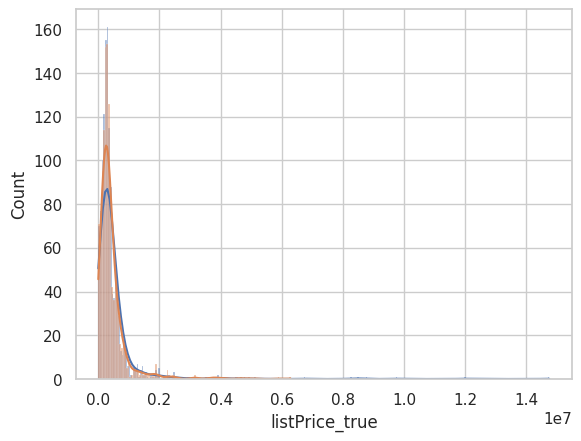

In [94]:
sns.histplot(comparative['listPrice_true'], kde=True)
sns.histplot(comparative['listPrice_pred'], kde=True)
